In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm

import sys
import os
import multiprocessing as mp
from joblib import Parallel, delayed

C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def test_stat_helper(vote_nodes, vote_classes, class_counts, K, kappa=3, base=2):
    """
    est_nodes : list
        Leaf indices used for voting
    eval_nodes : list
        Leaf indices in which a sample from the density subsample falls
    est_classes : list
        Voter class labels in est_node leaves
    """
    for i in range(len(vote_nodes)):
        class_counts[vote_nodes[i], vote_classes[i]] += 1

    # Total number of estimation points in each leaf.
    row_sums = class_counts.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]

    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but tha t will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis=1) == 0)] = [1 / K]*K
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / \
            (kappa*class_counts.sum(axis=1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    vote_class_probs = class_probs[vote_nodes]
    vote_entropies = [entropy(posterior, base=base)
                      for posterior in vote_class_probs]
    return np.mean(vote_entropies)


In [11]:
def uf(X, y, n_estimators=5, max_samples=.63, base=2, kappa=3, reps=100, n_jobs=None):
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              n_jobs=n_jobs,
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100

    #tree_est_nodes = []
    #tree_eval_nodes = []
    tree_vote_nodes = []
    tree_unsampled_indices = []

    # Get real test statistics
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0, n), sampled_indices)
        np.random.shuffle(unsampled_indices)
        tree_unsampled_indices.append(unsampled_indices)

        # Randomly split the rest into voting and evaluation.
        #vote_indices = unsampled_indices[:len(unsampled_indices)//2]
        #eval_indices = unsampled_indices[len(unsampled_indices)//2:]

        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        vote_nodes = tree.apply(X[unsampled_indices])
        tree_vote_nodes.append(vote_nodes)
        
        #est_nodes = tree.apply(X[vote_indices])
        #tree_est_nodes.append(est_nodes)
        #eval_nodes = tree.apply(X[eval_indices])
        #tree_eval_nodes.append(eval_nodes)

        cond_entropy += test_stat_helper(
            vote_nodes, y[unsampled_indices], class_counts, K)

    # Generate null dist
    # normally 1000-10,000 reps for null 
    for j in range(reps):
        for tree, unsampled_indices, vote_nodes in zip(
            model, tree_unsampled_indices, tree_vote_nodes
        ):
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            y_vote = y[unsampled_indices]
            np.random.shuffle(y_vote)
            final_null_dist[j] += test_stat_helper(
                vote_nodes, y_vote, class_counts, K)

    # note: shuffling y doesn't change these outputs
    new_final_null_dist = [entropy([np.mean(
        y), 1 - np.mean(y)], base=2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)],
                         base=2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist

In [21]:
MAX_SAMPLE_SIZE = 500
STEP_SIZE = 100 
SAMP_SIZES = range(100, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 100

SIMULATIONS = [
    # "linear": "Linear",
    # "multimodal_independence": "Independence"
    # linear,
    multimodal_independence
]

In [26]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
def estimate_power(sim, n_jobs=None):
    samp_size_dict = dict()
    samp_size_dict['sample_sizes'] = SAMP_SIZES
    samp_size_dict['n_power_reps'] = POWER_REPS
    power = []
    pvalues_list = []
    for n_samples in SAMP_SIZES:
        pvalues = []
        samp_size_dict[n_samples] = {'stats': [], 'null_dists': []}
        for p in tqdm(range(POWER_REPS)):
            #plt.clf()
            np.random.seed(None)
            matrix1, matrix2 = multimodal_independence(n_samples, 2)
            x, y = k_sample_transform([matrix1, matrix2])
            stat, null_dist = uf(x, y.ravel(), n_jobs=n_jobs)
            samp_size_dict[n_samples]['stats'].append(stat)
            samp_size_dict[n_samples]['null_dists'].append(null_dist)
            pvalue = np.mean(np.asarray(null_dist) >= stat)
            print("P-value: " + str(pvalue))
            print(f'Test stat: {stat}')
            print(f'Null dist: {null_dist[:5]}')
            #if p % 4 == 0: 
                #plt.hist(null_dist)
                #plt.axvline(stat, c='r', ls='--')
            #plt.show()
            pvalues.append(pvalue)
        pvalues_list.append(pvalues)
        #plt.hist(pvalues, range=(0,1))
        #plt.show()
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = 1 * x_vals
        plt.plot(x_vals, y_vals, '--')
        ecdf = ECDF(pvalues)
        plt.plot(ecdf.x, ecdf.y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("p-value")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.ylabel("fraction of data")
        plt.show()
        power.append(np.mean(np.asarray(pvalues) <= 0.05))
        #power.append((pvalues >= 0.05).sum() / POWER_REPS)

    with open('multimodal_independence_power_reps.pkl', 'wb') as handle:
        pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    np.savetxt('C:/Users/siptest/Desktop/NDD/multimodal_independence_power1000.csv',
               power, delimiter=',')

    return power, pvalues_list

  1%|▊                                                                                 | 1/100 [00:04<07:34,  4.59s/it]

P-value: 0.44
Test stat: 0.1716779299282415
Null dist: [0.17761625917600077, 0.12651491966207762, 0.18101515381442412, 0.2005277155771622, 0.17128061855303367]


  2%|█▋                                                                                | 2/100 [00:05<05:49,  3.57s/it]

P-value: 0.64
Test stat: 0.1666016272332944
Null dist: [0.17782081474819011, 0.16796771415690048, 0.16737036808894035, 0.17375651082965893, 0.17375650012644106]


  3%|██▍                                                                               | 3/100 [00:06<04:31,  2.80s/it]

P-value: 0.73
Test stat: 0.1484680355054886
Null dist: [0.18233142194767782, 0.16515375152347322, 0.17692627345092526, 0.1470595555661296, 0.18112269714435336]


  4%|███▎                                                                              | 4/100 [00:07<03:34,  2.23s/it]

P-value: 0.33
Test stat: 0.17074519600071003
Null dist: [0.1571395926105552, 0.16518469770122723, 0.2143020432945193, 0.12503597109664777, 0.16601189094121127]


  5%|████                                                                              | 5/100 [00:08<02:59,  1.89s/it]

P-value: 0.47
Test stat: 0.16639533597457468
Null dist: [0.16546156925271482, 0.13605652287674097, 0.18530899050395677, 0.17472579739702598, 0.16110471494443301]


  6%|████▉                                                                             | 6/100 [00:09<02:32,  1.62s/it]

P-value: 0.38
Test stat: 0.16884457629272265
Null dist: [0.18134142927426766, 0.13390208492898714, 0.16043896528408652, 0.1512830715849176, 0.18508942621089963]


  7%|█████▋                                                                            | 7/100 [00:10<02:11,  1.41s/it]

P-value: 0.05
Test stat: 0.1910075186044038
Null dist: [0.18331194405112716, 0.19784860123994696, 0.16672364472632428, 0.16689300443872512, 0.18620587287516377]


  8%|██████▌                                                                           | 8/100 [00:11<01:58,  1.29s/it]

P-value: 0.07
Test stat: 0.18904977633790487
Null dist: [0.1623578375746485, 0.14649121685936728, 0.1456355465187663, 0.14698473086041253, 0.160913636799771]


  9%|███████▍                                                                          | 9/100 [00:12<01:52,  1.23s/it]

P-value: 0.12
Test stat: 0.18308179493222665
Null dist: [0.15396059837949672, 0.14156352929454408, 0.17133674105786445, 0.1643989687993409, 0.16558884718527123]


 10%|████████                                                                         | 10/100 [00:14<01:52,  1.25s/it]

P-value: 0.8
Test stat: 0.14735927620015588
Null dist: [0.15429481181589177, 0.17000667722616603, 0.13859376950886781, 0.16887543604234256, 0.13865081435604143]


 11%|████████▉                                                                        | 11/100 [00:15<01:50,  1.24s/it]

P-value: 0.22
Test stat: 0.17296907857960464
Null dist: [0.131368730200076, 0.18199729208812554, 0.16111277141190017, 0.14692263620535917, 0.1506324848016023]


 12%|█████████▋                                                                       | 12/100 [00:16<01:40,  1.15s/it]

P-value: 0.4
Test stat: 0.1632088130821
Null dist: [0.17360174177477905, 0.1618914805565017, 0.156427027423663, 0.16313007231615306, 0.16141434842869518]


 13%|██████████▌                                                                      | 13/100 [00:17<01:35,  1.10s/it]

P-value: 0.03
Test stat: 0.1935891734059091
Null dist: [0.1542887311565172, 0.17451245486894051, 0.14948115107156246, 0.14601626695312753, 0.15486865782678316]


 14%|███████████▎                                                                     | 14/100 [00:18<01:31,  1.06s/it]

P-value: 0.99
Test stat: 0.11985044810470491
Null dist: [0.16760947599320686, 0.17213190880053353, 0.1630213943174441, 0.15473744121967992, 0.14871874759414094]


 15%|████████████▏                                                                    | 15/100 [00:19<01:34,  1.11s/it]

P-value: 0.88
Test stat: 0.14872584665713062
Null dist: [0.1776506854205968, 0.1737969712196994, 0.18139868235722878, 0.14441120805141383, 0.1937980491104595]


 16%|████████████▉                                                                    | 16/100 [00:20<01:29,  1.07s/it]

P-value: 0.7
Test stat: 0.15224180579092828
Null dist: [0.16306678605871028, 0.16152998290432996, 0.17885146092345516, 0.15597437445911022, 0.15311948770926698]


 17%|█████████████▊                                                                   | 17/100 [00:21<01:27,  1.05s/it]

P-value: 0.8
Test stat: 0.15178907253076834
Null dist: [0.16255925381178682, 0.15346615329093027, 0.1962473263731097, 0.14804189619913388, 0.14979668425685477]


 18%|██████████████▌                                                                  | 18/100 [00:22<01:24,  1.03s/it]

P-value: 0.32
Test stat: 0.16183113629435542
Null dist: [0.14852366664203998, 0.13761078056655252, 0.15698191484869572, 0.15069856657007308, 0.14627517290480674]


 19%|███████████████▍                                                                 | 19/100 [00:23<01:22,  1.02s/it]

P-value: 0.04
Test stat: 0.1990743225570265
Null dist: [0.22270019198541968, 0.18800352578654456, 0.1828344230893144, 0.18745335102979865, 0.1637503145984276]


 20%|████████████████▏                                                                | 20/100 [00:25<01:40,  1.26s/it]

P-value: 0.49
Test stat: 0.16170635184407622
Null dist: [0.11612367974053117, 0.15505139064425344, 0.18876847006990916, 0.18723703398122493, 0.18517713223078702]


 21%|█████████████████                                                                | 21/100 [00:26<01:34,  1.19s/it]

P-value: 0.86
Test stat: 0.15008784466951597
Null dist: [0.15255170920536187, 0.15178316687900573, 0.2014369547879833, 0.17239454913640095, 0.15873978027056634]


 22%|█████████████████▊                                                               | 22/100 [00:27<01:31,  1.17s/it]

P-value: 0.94
Test stat: 0.14525663411715883
Null dist: [0.16665518899410903, 0.1682457539969313, 0.1874443097232653, 0.1690948032611066, 0.16476998703043544]


 23%|██████████████████▋                                                              | 23/100 [00:28<01:26,  1.12s/it]

P-value: 0.66
Test stat: 0.1637310404896718
Null dist: [0.15408220693029961, 0.1534610750367824, 0.15159008614605318, 0.21901540733256042, 0.1710082551511627]


 24%|███████████████████▍                                                             | 24/100 [00:29<01:28,  1.16s/it]

P-value: 0.56
Test stat: 0.16894764037104282
Null dist: [0.18504258057017942, 0.1461545091016193, 0.1796473976101225, 0.150163140235005, 0.17096955905854228]


 25%|████████████████████▎                                                            | 25/100 [00:30<01:26,  1.15s/it]

P-value: 0.47
Test stat: 0.16049305715604267
Null dist: [0.11999684936943567, 0.1851063447087864, 0.17698325144791838, 0.2164149282581409, 0.14592791698709973]


 26%|█████████████████████                                                            | 26/100 [00:31<01:21,  1.10s/it]

P-value: 0.07
Test stat: 0.1813805978820231
Null dist: [0.16575198845048367, 0.12894826602750808, 0.1653952509180746, 0.14231452572347258, 0.1559372568249422]


 27%|█████████████████████▊                                                           | 27/100 [00:32<01:15,  1.03s/it]

P-value: 0.92
Test stat: 0.14006680516214998
Null dist: [0.14407575755334268, 0.16924630716078237, 0.16406766028042663, 0.14335387631456908, 0.15107174956183766]


 28%|██████████████████████▋                                                          | 28/100 [00:33<01:11,  1.00it/s]

P-value: 0.59
Test stat: 0.1681329846421038
Null dist: [0.17967591164175045, 0.15606503117270198, 0.1646688515935335, 0.17767164610771446, 0.18541871785335362]


 29%|███████████████████████▍                                                         | 29/100 [00:34<01:08,  1.04it/s]

P-value: 0.13
Test stat: 0.18516317399666204
Null dist: [0.17240709381102093, 0.14063420248435554, 0.16315712763929946, 0.17271299694234832, 0.12620763639642318]


 30%|████████████████████████▎                                                        | 30/100 [00:35<01:05,  1.07it/s]

P-value: 0.24
Test stat: 0.173018465600563
Null dist: [0.18239374351002025, 0.17378135003906703, 0.1694289999748756, 0.15157056179047879, 0.1495127037316768]


 31%|█████████████████████████                                                        | 31/100 [00:36<01:04,  1.07it/s]

P-value: 0.54
Test stat: 0.15134547176987867
Null dist: [0.16411583949051978, 0.13614528259799186, 0.15158900014103516, 0.13060680971536986, 0.13124819275884847]


 32%|█████████████████████████▉                                                       | 32/100 [00:37<01:04,  1.05it/s]

P-value: 0.13
Test stat: 0.18284276278637945
Null dist: [0.14005443303694476, 0.1804818438374104, 0.2075442554808844, 0.16768136237370734, 0.155763759155222]


 33%|██████████████████████████▋                                                      | 33/100 [00:38<01:05,  1.02it/s]

P-value: 0.48
Test stat: 0.1687345415169197
Null dist: [0.14231942747634674, 0.16224766795241996, 0.16096592433470358, 0.16234885559353773, 0.15575268349401727]


 34%|███████████████████████████▌                                                     | 34/100 [00:39<01:04,  1.03it/s]

P-value: 0.04
Test stat: 0.1658934543590016
Null dist: [0.15932948853936535, 0.1127530749550738, 0.14831543316587825, 0.12987512975337945, 0.1585164173569773]


 35%|████████████████████████████▎                                                    | 35/100 [00:40<01:02,  1.04it/s]

P-value: 0.01
Test stat: 0.19804917619358609
Null dist: [0.15315544262906644, 0.17590659515114027, 0.12560369535519678, 0.14874871102210674, 0.14751374353477986]


 36%|█████████████████████████████▏                                                   | 36/100 [00:41<01:04,  1.01s/it]

P-value: 0.73
Test stat: 0.16000019694314838
Null dist: [0.17101594162479827, 0.1657836304398137, 0.1377890914829788, 0.19807852446714524, 0.18605647746759657]


 37%|█████████████████████████████▉                                                   | 37/100 [00:42<01:02,  1.01it/s]

P-value: 0.38
Test stat: 0.16923959885989626
Null dist: [0.19021682195173573, 0.16986277620933676, 0.19577612494498986, 0.18793838651033412, 0.14055770950691593]


 38%|██████████████████████████████▊                                                  | 38/100 [00:43<01:02,  1.01s/it]

P-value: 0.86
Test stat: 0.14412357321541602
Null dist: [0.17725341106925951, 0.1421224066234954, 0.13588070978168576, 0.18562719024307994, 0.15313100137651914]


 39%|███████████████████████████████▌                                                 | 39/100 [00:44<01:05,  1.08s/it]

P-value: 0.58
Test stat: 0.1497216209782739
Null dist: [0.14808715162231822, 0.1504859378162875, 0.16767051663825894, 0.1569413656080595, 0.14277374039704616]


 40%|████████████████████████████████▍                                                | 40/100 [00:45<01:07,  1.13s/it]

P-value: 0.08
Test stat: 0.19516620754861835
Null dist: [0.17594905316170217, 0.1725985075054306, 0.1512737181924637, 0.16840504385095334, 0.19713085223025162]


 41%|█████████████████████████████████▏                                               | 41/100 [00:46<01:03,  1.08s/it]

P-value: 0.36
Test stat: 0.1698078353780671
Null dist: [0.1609709052953796, 0.1595365168804278, 0.14602754226807624, 0.1804386590773117, 0.16659918960671205]


 42%|██████████████████████████████████                                               | 42/100 [00:47<00:59,  1.02s/it]

P-value: 0.67
Test stat: 0.1508109978360782
Null dist: [0.12542048916879478, 0.16598388094390215, 0.1595887899992796, 0.1582095695905409, 0.16236884891042558]


 43%|██████████████████████████████████▊                                              | 43/100 [00:48<00:54,  1.04it/s]

P-value: 0.19
Test stat: 0.1817539777378201
Null dist: [0.1957038160764213, 0.16549287230828313, 0.18263003098132702, 0.1472636738765356, 0.17360787177152004]


 44%|███████████████████████████████████▋                                             | 44/100 [00:49<00:52,  1.08it/s]

P-value: 0.65
Test stat: 0.14972821381474544
Null dist: [0.1532496595620012, 0.15178896383712304, 0.14860621322849055, 0.167133437722504, 0.1557341261907862]


 45%|████████████████████████████████████▍                                            | 45/100 [00:50<00:51,  1.08it/s]

P-value: 0.8
Test stat: 0.1531896742327431
Null dist: [0.17633439046114618, 0.1716373443201029, 0.18407566201212722, 0.15208794710543005, 0.17958508297896714]


 46%|█████████████████████████████████████▎                                           | 46/100 [00:51<01:02,  1.16s/it]

P-value: 0.48
Test stat: 0.1615319815669496
Null dist: [0.14832893937455682, 0.14082118354269768, 0.1625246948483049, 0.157012093304016, 0.1505063477559926]


 47%|██████████████████████████████████████                                           | 47/100 [00:53<01:01,  1.16s/it]

P-value: 0.34
Test stat: 0.1666274414041794
Null dist: [0.15445534516391746, 0.21402353188857037, 0.15068901644813848, 0.12402935069259369, 0.19146280652113357]


 48%|██████████████████████████████████████▉                                          | 48/100 [00:54<00:58,  1.13s/it]

P-value: 0.12
Test stat: 0.1757515929309772
Null dist: [0.17046894530488488, 0.1502972991058089, 0.15035006915038074, 0.17144447536144336, 0.14449476748443535]


 49%|███████████████████████████████████████▋                                         | 49/100 [00:55<00:55,  1.08s/it]

P-value: 0.36
Test stat: 0.1726707040612292
Null dist: [0.17658756789791785, 0.15512203164492389, 0.19056739122506472, 0.17418238422458043, 0.19787052220713597]


 50%|████████████████████████████████████████▌                                        | 50/100 [00:56<00:51,  1.04s/it]

P-value: 0.75
Test stat: 0.1564314422283608
Null dist: [0.17308100350820188, 0.1484911878863393, 0.15738200013787418, 0.17820534363944096, 0.1740659309461009]


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:56<00:48,  1.02it/s]

P-value: 0.7
Test stat: 0.15005641941835302
Null dist: [0.13560716502647663, 0.16519677607202987, 0.15096572950987175, 0.15111522543487887, 0.1405658893076085]


 52%|██████████████████████████████████████████                                       | 52/100 [00:57<00:44,  1.07it/s]

P-value: 0.92
Test stat: 0.14166685028151738
Null dist: [0.19838837327497172, 0.14198002837242052, 0.16414044233650338, 0.17970283727443237, 0.1721584164807981]


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:58<00:42,  1.11it/s]

P-value: 0.23
Test stat: 0.16928717688424777
Null dist: [0.1538940759301719, 0.17179608581190953, 0.17742911130399097, 0.15586382136200572, 0.1442877513039338]


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:59<00:40,  1.13it/s]

P-value: 0.79
Test stat: 0.15819261784403627
Null dist: [0.19836162723138195, 0.1797692237975983, 0.18425348277732068, 0.14876902413696325, 0.17537643394457036]


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:00<00:38,  1.16it/s]

P-value: 0.76
Test stat: 0.1542695570719952
Null dist: [0.17771629428331415, 0.19890898638908538, 0.1725723275508224, 0.1566870337143722, 0.2017622153042935]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:01<00:37,  1.17it/s]

P-value: 0.1
Test stat: 0.18258152705987185
Null dist: [0.1568676277064135, 0.16404480920255937, 0.155107950915103, 0.17670813749246628, 0.13713691714227794]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:01<00:36,  1.18it/s]

P-value: 0.51
Test stat: 0.15808123731951906
Null dist: [0.16214767996329038, 0.1481342640344675, 0.1482149807212052, 0.14786382332031545, 0.17071662058629467]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:02<00:35,  1.18it/s]

P-value: 0.25
Test stat: 0.165546335408715
Null dist: [0.14445960076184183, 0.16568728585109993, 0.14109904784460137, 0.13790761226764192, 0.15625187968069798]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:03<00:34,  1.18it/s]

P-value: 0.09
Test stat: 0.1708981161998906
Null dist: [0.17130005151536043, 0.1543090095597769, 0.14532792671037087, 0.1518515023408803, 0.16209032291930592]


 60%|████████████████████████████████████████████████▌                                | 60/100 [01:04<00:34,  1.17it/s]

P-value: 0.85
Test stat: 0.1447423709491995
Null dist: [0.17042781490911363, 0.13577801973904224, 0.15717522575284648, 0.155564703906224, 0.15770565811100923]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:05<00:33,  1.17it/s]

P-value: 0.66
Test stat: 0.1630377752722192
Null dist: [0.1452554722977346, 0.18909308029485783, 0.17943115074593907, 0.16157985012210607, 0.17469870411833155]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:06<00:31,  1.19it/s]

P-value: 1.0
Test stat: 0.14137168736702566
Null dist: [0.1711778795713943, 0.1866572413807137, 0.17802100979677782, 0.15132061249959983, 0.1672836515451751]


 63%|███████████████████████████████████████████████████                              | 63/100 [01:06<00:30,  1.20it/s]

P-value: 0.4
Test stat: 0.14960584988508763
Null dist: [0.14421404492815704, 0.1430182856134149, 0.15730319080664257, 0.13273771623682384, 0.1348041382348335]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:07<00:29,  1.21it/s]

P-value: 0.91
Test stat: 0.13638600346594032
Null dist: [0.1515547335754126, 0.17279726580397925, 0.14847503466673773, 0.1611737056040775, 0.15922826868033657]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:08<00:28,  1.21it/s]

P-value: 0.83
Test stat: 0.1483250095910671
Null dist: [0.1653190992509419, 0.1651982370278956, 0.16399743537276534, 0.14524999303250008, 0.16536896800811385]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:09<00:28,  1.18it/s]

P-value: 0.15
Test stat: 0.18635191030930154
Null dist: [0.1850473047538005, 0.12421344535386825, 0.1727393022867384, 0.16478300549917968, 0.15193933720709474]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:10<00:28,  1.17it/s]

P-value: 0.19
Test stat: 0.1732570207861336
Null dist: [0.17861785491912074, 0.16306232902733986, 0.17258687365319714, 0.12248767586706655, 0.18826577786132748]


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:11<00:27,  1.16it/s]

P-value: 0.7
Test stat: 0.15543624398250222
Null dist: [0.17230258553563138, 0.1611696798040979, 0.13988046327017556, 0.1608216883984387, 0.15608133625704157]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:12<00:26,  1.16it/s]

P-value: 0.99
Test stat: 0.13167754787731556
Null dist: [0.17657497357662444, 0.15119514810743873, 0.16397237555040367, 0.15731373289993034, 0.16847977764366318]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:12<00:25,  1.18it/s]

P-value: 0.01
Test stat: 0.20128488208818907
Null dist: [0.1485464340338687, 0.15779040562320668, 0.16440763858063678, 0.17377242705857, 0.14547581913814356]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:13<00:24,  1.18it/s]

P-value: 0.9
Test stat: 0.1442135671224427
Null dist: [0.16255364298187125, 0.14669890381662276, 0.19250512417110988, 0.1743584251768029, 0.1732532526800028]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:14<00:23,  1.18it/s]

P-value: 0.4
Test stat: 0.16178800527786907
Null dist: [0.1328373051056848, 0.1601451205360721, 0.17995344426311388, 0.1715808203592768, 0.1474700061008345]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:15<00:22,  1.18it/s]

P-value: 0.07
Test stat: 0.18231745865586912
Null dist: [0.15846164476051716, 0.17333521514541383, 0.17974775716634528, 0.14136356884562906, 0.19810070500805277]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:16<00:22,  1.16it/s]

P-value: 0.94
Test stat: 0.14069799294369167
Null dist: [0.1366283520676227, 0.16483130041639815, 0.17953139067806367, 0.15934500251928885, 0.16144790027360822]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:17<00:21,  1.17it/s]

P-value: 0.12
Test stat: 0.18182801020999118
Null dist: [0.13962096623566433, 0.17358702766344736, 0.18101786037001555, 0.185372544332145, 0.15989671739265243]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:17<00:20,  1.17it/s]

P-value: 0.18
Test stat: 0.18447124088756495
Null dist: [0.14013351067071333, 0.1649777384360609, 0.18000593174055868, 0.17854635969866917, 0.19788702986594964]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:18<00:19,  1.16it/s]

P-value: 0.69
Test stat: 0.14866857865634464
Null dist: [0.14443493996667145, 0.11669693235655987, 0.15906803750296028, 0.15123441292012418, 0.15171064345005936]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:19<00:19,  1.16it/s]

P-value: 0.51
Test stat: 0.16532877250498568
Null dist: [0.1787754772295912, 0.17329123369688626, 0.16731489149947798, 0.19987794486101984, 0.13980791376859636]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:20<00:18,  1.13it/s]

P-value: 0.21
Test stat: 0.17488544910119808
Null dist: [0.1797532924406875, 0.14116568526055073, 0.16017840733809852, 0.15386891692755678, 0.1657733825384241]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:21<00:17,  1.13it/s]

P-value: 0.76
Test stat: 0.1467725291016937
Null dist: [0.13138215807028375, 0.16021076720263383, 0.12625185195052535, 0.17430114639243544, 0.1740937357009983]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:22<00:16,  1.13it/s]

P-value: 0.3
Test stat: 0.18094152455151014
Null dist: [0.18217131563836375, 0.13008783882016206, 0.17731321136924705, 0.17188035557099468, 0.1364774044647643]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:23<00:15,  1.13it/s]

P-value: 0.36
Test stat: 0.17185257564623202
Null dist: [0.13460875507667436, 0.17364685109417122, 0.17059316695216786, 0.18417796103386386, 0.17681020583488272]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:24<00:15,  1.12it/s]

P-value: 0.6
Test stat: 0.15208355256453798
Null dist: [0.14039652077884812, 0.18488546311614817, 0.16581853655563916, 0.13064521050445177, 0.16807769806736683]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:25<00:14,  1.13it/s]

P-value: 0.67
Test stat: 0.1590130173171005
Null dist: [0.16200539316762685, 0.1503161339104555, 0.14650985887228385, 0.17259871135855376, 0.17607406873386533]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:26<00:13,  1.11it/s]

P-value: 0.02
Test stat: 0.19323104235395883
Null dist: [0.15601433786939567, 0.174343464446156, 0.15887606442521984, 0.1583624695911492, 0.15659602354223412]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:26<00:12,  1.11it/s]

P-value: 0.81
Test stat: 0.14225722994485435
Null dist: [0.17377626100429178, 0.1352210289751643, 0.15250806960343888, 0.1616523246080197, 0.1551013951708844]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:27<00:11,  1.12it/s]

P-value: 0.26
Test stat: 0.17516554041060783
Null dist: [0.1704714342138154, 0.15337776820593219, 0.16790542565329147, 0.13564406914725835, 0.15884033194870084]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:28<00:10,  1.11it/s]

P-value: 0.06
Test stat: 0.19843148620755802
Null dist: [0.14839820516198343, 0.18585100167166113, 0.16088640628025974, 0.17376214096102305, 0.15105984374617398]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:29<00:09,  1.11it/s]

P-value: 0.66
Test stat: 0.16186026692285116
Null dist: [0.15442639266804714, 0.19479378711593165, 0.1767419821381161, 0.14517660392032639, 0.14883080155072415]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:30<00:08,  1.15it/s]

P-value: 0.58
Test stat: 0.15935344691361197
Null dist: [0.13863538851478252, 0.14842201603896432, 0.15370409637503823, 0.14987906659648487, 0.14569862535019618]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:31<00:07,  1.16it/s]

P-value: 0.02
Test stat: 0.18470069269004585
Null dist: [0.14440429995488668, 0.11752915749068349, 0.15660636431941266, 0.16178623043401197, 0.15825229309146283]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:32<00:06,  1.17it/s]

P-value: 0.35
Test stat: 0.16940130096334838
Null dist: [0.15298713412134468, 0.15217861278297717, 0.1590346395443506, 0.16615430626465655, 0.183183810535669]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:32<00:05,  1.18it/s]

P-value: 0.49
Test stat: 0.16219856092590013
Null dist: [0.14522293017294463, 0.14181673570535236, 0.1466127751416979, 0.1942016391003596, 0.1735491287411126]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:33<00:05,  1.16it/s]

P-value: 0.73
Test stat: 0.14799246419842738
Null dist: [0.1419176502484205, 0.15370829299008837, 0.14929317917021323, 0.161854542587762, 0.18005418420490749]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:34<00:04,  1.16it/s]

P-value: 0.42
Test stat: 0.17284869128605318
Null dist: [0.20001513205357457, 0.17259818201667265, 0.18192701239405085, 0.1629290147412401, 0.16759686376330651]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:35<00:03,  1.17it/s]

P-value: 0.67
Test stat: 0.15988826269072676
Null dist: [0.14884618582778886, 0.175691976984916, 0.18996747175189144, 0.1864486773769798, 0.16039667561834103]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:36<00:02,  1.17it/s]

P-value: 0.18
Test stat: 0.16902179581975063
Null dist: [0.15885845824829192, 0.16316835968227728, 0.17272506320258985, 0.16280857209874955, 0.1582291045432045]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:37<00:01,  1.17it/s]

P-value: 0.03
Test stat: 0.19855310559847417
Null dist: [0.1748849388775664, 0.14689477127298234, 0.16576878086993463, 0.1616584651296218, 0.14344997634396306]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:38<00:00,  1.14it/s]

P-value: 0.44
Test stat: 0.16040778674236333
Null dist: [0.15780708138872668, 0.17531660970669272, 0.18572280622253656, 0.15262027305336245, 0.1732587345156844]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]

P-value: 0.47
Test stat: 0.16813908406235833
Null dist: [0.1641781167823636, 0.17880822256653306, 0.17838475510417307, 0.1550355588047596, 0.18458158131542102]


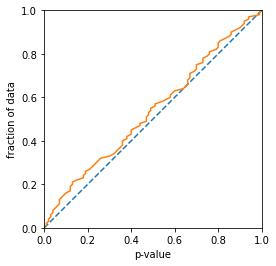

  1%|▊                                                                                 | 1/100 [00:01<02:55,  1.78s/it]

P-value: 0.04
Test stat: 0.17605388066377914
Null dist: [0.15254287684805412, 0.14031186542238105, 0.14937751969178348, 0.15526704654199486, 0.15379414293053928]


  2%|█▋                                                                                | 2/100 [00:03<02:50,  1.74s/it]

P-value: 0.32
Test stat: 0.17274562437607932
Null dist: [0.1616071488687323, 0.19082360575075552, 0.15375810066790074, 0.17315545795823706, 0.1615912109737957]


  3%|██▍                                                                               | 3/100 [00:05<02:46,  1.71s/it]

P-value: 0.4
Test stat: 0.16583850592439298
Null dist: [0.17344877203027875, 0.15540260257875071, 0.15362061861661758, 0.1549466197102788, 0.16931582863199313]


  4%|███▎                                                                              | 4/100 [00:06<02:42,  1.70s/it]

P-value: 0.61
Test stat: 0.1561966747802972
Null dist: [0.15605678173906712, 0.16052982304208585, 0.1723671074330818, 0.149025551573717, 0.18758724185767384]


  5%|████                                                                              | 5/100 [00:08<02:39,  1.68s/it]

P-value: 0.32
Test stat: 0.16981691421627265
Null dist: [0.15889229532152993, 0.15736088314354468, 0.1698440848912227, 0.14960807143669652, 0.1656674130591591]


  6%|████▉                                                                             | 6/100 [00:10<02:38,  1.68s/it]

P-value: 0.13
Test stat: 0.16851213908717555
Null dist: [0.14740170184577628, 0.1442114158377551, 0.16603175693145755, 0.15759965082309935, 0.15039951921592165]


  7%|█████▋                                                                            | 7/100 [00:11<02:36,  1.68s/it]

P-value: 0.02
Test stat: 0.19178884065676838
Null dist: [0.15727883346047888, 0.17331815743130807, 0.18393291232289344, 0.15632125801827268, 0.1709474542031314]


  8%|██████▌                                                                           | 8/100 [00:13<02:36,  1.70s/it]

P-value: 0.53
Test stat: 0.16405792893700077
Null dist: [0.18506090722343482, 0.1680395705251463, 0.1862049924032586, 0.15224306366311335, 0.15812465995164238]


  9%|███████▍                                                                          | 9/100 [00:15<02:33,  1.69s/it]

P-value: 0.59
Test stat: 0.16424432472768413
Null dist: [0.18119276088481373, 0.156920677317944, 0.1548217245914406, 0.1596321607997444, 0.178652353077003]


 10%|████████                                                                         | 10/100 [00:16<02:35,  1.72s/it]

P-value: 0.18
Test stat: 0.1710824475490179
Null dist: [0.16392437793930037, 0.14344998654978114, 0.16402078665396458, 0.16039050124840792, 0.16579026256504625]


 11%|████████▉                                                                        | 11/100 [00:19<02:45,  1.86s/it]

P-value: 0.76
Test stat: 0.15340887180930163
Null dist: [0.1623687339156532, 0.16543464204931657, 0.17735463468327772, 0.15819201037725572, 0.15479839527540773]


 12%|█████████▋                                                                       | 12/100 [00:20<02:35,  1.77s/it]

P-value: 0.9
Test stat: 0.14755019702688177
Null dist: [0.17411150127310182, 0.16981028253192076, 0.14895513800599447, 0.14940043900204747, 0.1842242463134527]


 13%|██████████▌                                                                      | 13/100 [00:22<02:28,  1.71s/it]

P-value: 0.51
Test stat: 0.16313769901594655
Null dist: [0.15869262707897536, 0.1681272787376994, 0.15331819339555008, 0.16565995875631556, 0.15529207940727496]


 14%|███████████▎                                                                     | 14/100 [00:23<02:24,  1.68s/it]

P-value: 0.79
Test stat: 0.15371631944717978
Null dist: [0.14491455220323424, 0.15140685162957457, 0.15679459176524413, 0.1675822989520217, 0.13361937775519928]


 15%|████████████▏                                                                    | 15/100 [00:25<02:20,  1.65s/it]

P-value: 0.19
Test stat: 0.1748109105965614
Null dist: [0.17061645590498264, 0.1819081878152463, 0.18235281615037346, 0.1726562829138747, 0.17766248478507907]


 16%|████████████▉                                                                    | 16/100 [00:27<02:20,  1.67s/it]

P-value: 0.89
Test stat: 0.1492255468176552
Null dist: [0.1722385037724784, 0.15811688198219986, 0.16136808604881614, 0.1650837552218809, 0.17019455080372237]


 17%|█████████████▊                                                                   | 17/100 [00:28<02:19,  1.68s/it]

P-value: 0.62
Test stat: 0.15863198488576313
Null dist: [0.16320448387606967, 0.1695450769308875, 0.1575663761271755, 0.16999705782435703, 0.17528266514580826]


 18%|██████████████▌                                                                  | 18/100 [00:30<02:19,  1.70s/it]

P-value: 0.55
Test stat: 0.16744353559982328
Null dist: [0.15913030835704056, 0.16864871325363073, 0.16879993263271675, 0.16347580365341163, 0.18386733303084513]


 19%|███████████████▍                                                                 | 19/100 [00:32<02:17,  1.69s/it]

P-value: 0.11
Test stat: 0.1748915365962167
Null dist: [0.1542601422637937, 0.16470862934644226, 0.15787496018739344, 0.16166298199119977, 0.14825249690086328]


 20%|████████████████▏                                                                | 20/100 [00:33<02:13,  1.67s/it]

P-value: 0.72
Test stat: 0.15293470660544983
Null dist: [0.16525412074986878, 0.15936609029587157, 0.16112790813888156, 0.17107442105060966, 0.1582803271037625]


 21%|█████████████████                                                                | 21/100 [00:35<02:11,  1.66s/it]

P-value: 0.6
Test stat: 0.17096885271343254
Null dist: [0.16046084567819852, 0.18807937007302122, 0.1894435922935651, 0.18226840424739943, 0.1809087788369863]


 22%|█████████████████▊                                                               | 22/100 [00:37<02:07,  1.64s/it]

P-value: 0.85
Test stat: 0.16135747978396786
Null dist: [0.17252794320849696, 0.17948766234267788, 0.19859729789348424, 0.1656028081211648, 0.17069894500622007]


 23%|██████████████████▋                                                              | 23/100 [00:38<02:07,  1.66s/it]

P-value: 0.69
Test stat: 0.15668738124741988
Null dist: [0.15005593883115975, 0.15662475623042948, 0.17465246447899807, 0.17912218988526063, 0.16920681256893444]


 24%|███████████████████▍                                                             | 24/100 [00:40<02:06,  1.66s/it]

P-value: 0.21
Test stat: 0.17210866418484316
Null dist: [0.15443608111881768, 0.15548921171143382, 0.16064927204313995, 0.1518270508066546, 0.15957091305905047]


 25%|████████████████████▎                                                            | 25/100 [00:42<02:10,  1.74s/it]

P-value: 0.6
Test stat: 0.16315702157262157
Null dist: [0.16820987766781637, 0.13905509067227606, 0.16121539689621045, 0.16431364906367685, 0.15974822342547024]


 26%|█████████████████████                                                            | 26/100 [00:44<02:13,  1.80s/it]

P-value: 0.1
Test stat: 0.1772686248601818
Null dist: [0.14653248461282709, 0.15022722767976793, 0.17779985299539125, 0.17722474776918795, 0.1657429000995826]


 27%|█████████████████████▊                                                           | 27/100 [00:46<02:08,  1.76s/it]

P-value: 0.04
Test stat: 0.17932946332755295
Null dist: [0.17417676592081732, 0.15534294081100575, 0.1601530666665505, 0.15230386985811395, 0.16140004517992124]


 28%|██████████████████████▋                                                          | 28/100 [00:48<02:11,  1.83s/it]

P-value: 0.11
Test stat: 0.1772238027856059
Null dist: [0.16225029842293703, 0.13238160323733705, 0.14208933287869152, 0.18073542699521317, 0.15580697487920303]


 29%|███████████████████████▍                                                         | 29/100 [00:49<02:08,  1.81s/it]

P-value: 0.7
Test stat: 0.16273610409473138
Null dist: [0.1566815347357291, 0.17323469219811893, 0.16995415341651798, 0.15689051821819366, 0.14640048430356212]


 30%|████████████████████████▎                                                        | 30/100 [00:51<02:03,  1.77s/it]

P-value: 0.69
Test stat: 0.15406748889715483
Null dist: [0.16080170125547844, 0.14221094175960336, 0.1503671692668318, 0.15496583107337436, 0.14642891187120455]


 31%|█████████████████████████                                                        | 31/100 [00:53<02:00,  1.74s/it]

P-value: 0.62
Test stat: 0.15946797351964148
Null dist: [0.1493520141806457, 0.16730894186659406, 0.17756162381148322, 0.16555528284409038, 0.17835890481798022]


 32%|█████████████████████████▉                                                       | 32/100 [00:54<01:57,  1.72s/it]

P-value: 0.73
Test stat: 0.15912028933188582
Null dist: [0.1827953597720965, 0.1614101933868648, 0.16135165316400557, 0.19122306089936403, 0.17166767744542055]


 33%|██████████████████████████▋                                                      | 33/100 [00:56<01:54,  1.71s/it]

P-value: 0.29
Test stat: 0.1665357903504281
Null dist: [0.15770194408126592, 0.15606591620814192, 0.15400898105554917, 0.1535220827454914, 0.15531199688243214]


 34%|███████████████████████████▌                                                     | 34/100 [00:58<01:51,  1.69s/it]

P-value: 0.4
Test stat: 0.1652551834863647
Null dist: [0.14915141081469918, 0.18130599371276923, 0.1481462098083416, 0.151763834343982, 0.1532996855579658]


 35%|████████████████████████████▎                                                    | 35/100 [00:59<01:50,  1.70s/it]

P-value: 0.62
Test stat: 0.1592933871011324
Null dist: [0.15529571027262956, 0.14646392682477694, 0.15022040117490365, 0.15088256557571178, 0.1722317038802894]


 36%|█████████████████████████████▏                                                   | 36/100 [01:01<01:50,  1.72s/it]

P-value: 0.58
Test stat: 0.1530236208220096
Null dist: [0.16524755759642518, 0.15775163591569696, 0.16380893046909772, 0.1723724295851412, 0.16072996360044045]


 37%|█████████████████████████████▉                                                   | 37/100 [01:03<01:48,  1.72s/it]

P-value: 0.87
Test stat: 0.1563353348955827
Null dist: [0.1883785091035387, 0.2034104697617265, 0.16980557497105286, 0.17972417488497905, 0.1763425747412084]


 38%|██████████████████████████████▊                                                  | 38/100 [01:05<01:46,  1.73s/it]

P-value: 0.24
Test stat: 0.17197398097271976
Null dist: [0.1550653259161352, 0.1448580639687842, 0.1479847175370047, 0.13596282784490898, 0.17215102731240428]


 39%|███████████████████████████████▌                                                 | 39/100 [01:06<01:45,  1.73s/it]

P-value: 0.17
Test stat: 0.17656435976750173
Null dist: [0.15878930241815126, 0.16436495342336666, 0.18074653100448435, 0.17211150261614883, 0.17365456048792183]


 40%|████████████████████████████████▍                                                | 40/100 [01:08<01:44,  1.74s/it]

P-value: 0.65
Test stat: 0.1598647911428206
Null dist: [0.16303022372438458, 0.17197566827263044, 0.1797005957788338, 0.15694609730031206, 0.18883799480591057]


 41%|█████████████████████████████████▏                                               | 41/100 [01:10<01:41,  1.72s/it]

P-value: 0.58
Test stat: 0.15058618660604461
Null dist: [0.1542725151955896, 0.14269592957243682, 0.16401666502233692, 0.15255877108193727, 0.1339929354616869]


 42%|██████████████████████████████████                                               | 42/100 [01:12<01:40,  1.73s/it]

P-value: 0.94
Test stat: 0.14850487782483823
Null dist: [0.16928323334703888, 0.16325194743566696, 0.15745121449424604, 0.17515925678295474, 0.1348850514833737]


 43%|██████████████████████████████████▊                                              | 43/100 [01:13<01:38,  1.72s/it]

P-value: 0.17
Test stat: 0.16781580472835544
Null dist: [0.1439039336384086, 0.16398267109784848, 0.17632019247544461, 0.14829641331282173, 0.16952846679580547]


 44%|███████████████████████████████████▋                                             | 44/100 [01:15<01:38,  1.76s/it]

P-value: 0.55
Test stat: 0.15648600199189833
Null dist: [0.14232526380725985, 0.14267104829047095, 0.15193781016377872, 0.1512908404235762, 0.17105851804588157]


 45%|████████████████████████████████████▍                                            | 45/100 [01:17<01:36,  1.76s/it]

P-value: 0.74
Test stat: 0.1531386407844405
Null dist: [0.15263333752117636, 0.15236656082300226, 0.18722771582292697, 0.14384389013955923, 0.15654737872090363]


 46%|█████████████████████████████████████▎                                           | 46/100 [01:18<01:33,  1.73s/it]

P-value: 0.34
Test stat: 0.16541969936896916
Null dist: [0.1440687260897221, 0.1533227734808772, 0.16612031238113367, 0.16541570311595954, 0.16101479081812564]


 47%|██████████████████████████████████████                                           | 47/100 [01:20<01:29,  1.69s/it]

P-value: 0.46
Test stat: 0.16929064565187013
Null dist: [0.1719657210778054, 0.17487379151720062, 0.16611853808588428, 0.15876344195870296, 0.17844204903293037]


 48%|██████████████████████████████████████▉                                          | 48/100 [01:22<01:28,  1.69s/it]

P-value: 0.74
Test stat: 0.15680596659885349
Null dist: [0.17863089712663793, 0.15381529759939117, 0.16954660833148638, 0.15594962131731516, 0.1585679089870229]


 49%|███████████████████████████████████████▋                                         | 49/100 [01:23<01:26,  1.70s/it]

P-value: 0.73
Test stat: 0.16215840745675902
Null dist: [0.15417590275901227, 0.16272390147542237, 0.16069521562928712, 0.15909587242188583, 0.1707400700335182]


 50%|████████████████████████████████████████▌                                        | 50/100 [01:25<01:24,  1.68s/it]

P-value: 0.1
Test stat: 0.17326218292904816
Null dist: [0.14493281927320234, 0.1462027875859031, 0.174574945454809, 0.15182001863991856, 0.16370695222508314]


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:27<01:21,  1.66s/it]

P-value: 0.05
Test stat: 0.1764195519000753
Null dist: [0.1628918033150677, 0.16382741083564356, 0.1667056223728267, 0.1540727667917281, 0.17109153311201852]


 52%|██████████████████████████████████████████                                       | 52/100 [01:28<01:19,  1.67s/it]

P-value: 0.89
Test stat: 0.14906327685539833
Null dist: [0.1537466057121719, 0.15703137877199025, 0.15468364415716473, 0.15466117025436754, 0.15609920416115552]


 53%|██████████████████████████████████████████▉                                      | 53/100 [01:30<01:19,  1.68s/it]

P-value: 0.99
Test stat: 0.14611669653838621
Null dist: [0.15923518732890485, 0.1526861209994662, 0.1783445695385263, 0.15028290593590443, 0.17035822579334803]


 54%|███████████████████████████████████████████▋                                     | 54/100 [01:32<01:17,  1.69s/it]

P-value: 0.3
Test stat: 0.16864028808582032
Null dist: [0.16368717676293232, 0.15304223928284932, 0.1630141955856541, 0.17484658995284508, 0.16785443186027282]


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:34<01:15,  1.69s/it]

P-value: 0.58
Test stat: 0.16128154978024833
Null dist: [0.15899753604494316, 0.1602896193743334, 0.14876898581961306, 0.1754755132093473, 0.15882498632390118]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:35<01:14,  1.69s/it]

P-value: 0.76
Test stat: 0.15194955195463677
Null dist: [0.1599889011600648, 0.16314059904422984, 0.1435278206855607, 0.15996816505800004, 0.15096962062280173]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:37<01:12,  1.70s/it]

P-value: 0.09
Test stat: 0.1745326614508853
Null dist: [0.16249283722757768, 0.1732111744903786, 0.13293747446823656, 0.16204809433211087, 0.1506252934172716]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:39<01:14,  1.77s/it]

P-value: 0.02
Test stat: 0.18268651567529515
Null dist: [0.14882430702062588, 0.17169164755378308, 0.14273489221073277, 0.15695252305202023, 0.16164261283229298]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:41<01:13,  1.80s/it]

P-value: 0.98
Test stat: 0.13853606160418086
Null dist: [0.1568608553023324, 0.15626359227214448, 0.16352227884075832, 0.169945527593225, 0.14921065962805502]


 60%|████████████████████████████████████████████████▌                                | 60/100 [01:42<01:10,  1.77s/it]

P-value: 0.47
Test stat: 0.15638301284444167
Null dist: [0.13874379491293376, 0.1598949115524564, 0.14955846350064483, 0.1594882536348532, 0.14011325842382827]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:44<01:08,  1.75s/it]

P-value: 0.87
Test stat: 0.1485133840967755
Null dist: [0.15003084694401547, 0.15561178854235957, 0.15895290792974048, 0.16651145037227388, 0.13827480162886796]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:46<01:05,  1.73s/it]

P-value: 0.5
Test stat: 0.15680152682677329
Null dist: [0.1567858439371591, 0.16023283460475324, 0.18787540456577556, 0.1731756367697127, 0.1681061687858918]


 63%|███████████████████████████████████████████████████                              | 63/100 [01:48<01:03,  1.72s/it]

P-value: 0.22
Test stat: 0.17444573219551407
Null dist: [0.13615296868582993, 0.1550012510649561, 0.15422429679996374, 0.15164098651772373, 0.16399271267496118]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:49<01:01,  1.71s/it]

P-value: 0.66
Test stat: 0.1535593089870566
Null dist: [0.18795990682466623, 0.16201764528659024, 0.17284148119549414, 0.16185657596852054, 0.17229529436788393]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:51<00:59,  1.71s/it]

P-value: 0.09
Test stat: 0.17879334850622608
Null dist: [0.14705820587793705, 0.16936320899301305, 0.16494703381824216, 0.16579598958436015, 0.1906798254480645]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:53<00:57,  1.70s/it]

P-value: 0.33
Test stat: 0.1643708972836848
Null dist: [0.15603508259076837, 0.16446565556328174, 0.16195643870962273, 0.14834644776536954, 0.16203231283702613]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:55<00:59,  1.81s/it]

P-value: 0.58
Test stat: 0.15571239040571105
Null dist: [0.16271875664168112, 0.14932075313812554, 0.15653620075701924, 0.17109983786826422, 0.1560765864869721]


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:57<01:07,  2.11s/it]

P-value: 0.55
Test stat: 0.16589279211487162
Null dist: [0.16953053040912425, 0.16548023958597136, 0.16333753430464704, 0.16108525985135425, 0.16053000165726472]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:59<01:01,  1.99s/it]

P-value: 0.5
Test stat: 0.1629081949138882
Null dist: [0.18145262204803048, 0.16058796438648382, 0.1761712476767876, 0.1756127768030875, 0.15400529369082105]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [02:01<00:56,  1.90s/it]

P-value: 0.74
Test stat: 0.1526033286835855
Null dist: [0.16317293281051837, 0.1493692347679232, 0.15109509952029876, 0.1519712325711169, 0.16798667681671797]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [02:03<00:53,  1.83s/it]

P-value: 0.99
Test stat: 0.14514326167392055
Null dist: [0.15874117593117698, 0.16599793031603416, 0.17122153792649542, 0.17725380360379306, 0.15904651999894115]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [02:04<00:50,  1.79s/it]

P-value: 0.4
Test stat: 0.1642331961673369
Null dist: [0.15154155075605724, 0.16214412548998003, 0.1880209333149928, 0.15296139047897594, 0.14097377428531543]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [02:06<00:47,  1.77s/it]

P-value: 0.59
Test stat: 0.15545636493425674
Null dist: [0.15197383885703053, 0.14978003954565666, 0.1642507977532166, 0.16444717214605264, 0.13955132980307172]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [02:08<00:45,  1.75s/it]

P-value: 0.16
Test stat: 0.17425178085441106
Null dist: [0.16989158021947248, 0.15674360261335774, 0.1738641486244582, 0.16784488034448208, 0.16878039867764083]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [02:09<00:43,  1.74s/it]

P-value: 0.79
Test stat: 0.1560580911820667
Null dist: [0.1833154931834926, 0.16072772841929228, 0.17236679193567572, 0.1579373775601669, 0.15989352739517382]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [02:11<00:41,  1.72s/it]

P-value: 0.06
Test stat: 0.17812843134842404
Null dist: [0.1738735007551705, 0.15756706485331728, 0.14752592869110648, 0.15372149105150024, 0.1660515906957365]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [02:13<00:39,  1.72s/it]

P-value: 0.73
Test stat: 0.15344652287170424
Null dist: [0.15971774084151558, 0.17657110722666514, 0.17758997858067072, 0.15680433120795456, 0.13902140232827254]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [02:14<00:37,  1.71s/it]

P-value: 0.26
Test stat: 0.1691183481750329
Null dist: [0.16239815825575565, 0.13584594900636782, 0.17857804924366882, 0.16894293658208448, 0.1628939974389212]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [02:16<00:35,  1.70s/it]

P-value: 0.43
Test stat: 0.1631307417118253
Null dist: [0.14547094007013417, 0.18065549709553896, 0.19447037868410744, 0.19174234923557432, 0.1700455095920953]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [02:18<00:34,  1.71s/it]

P-value: 0.68
Test stat: 0.15770216866986608
Null dist: [0.165866379779256, 0.1576165049548457, 0.15171695017602826, 0.1602772987990685, 0.17536078599725047]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [02:20<00:32,  1.69s/it]

P-value: 0.08
Test stat: 0.1754477551588115
Null dist: [0.1568852429126213, 0.149546024991847, 0.1678229731398263, 0.18080603592784317, 0.14621306692365632]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [02:21<00:30,  1.68s/it]

P-value: 0.51
Test stat: 0.158837871131024
Null dist: [0.1587611812180395, 0.16294514077139755, 0.17472370155350192, 0.149643714814213, 0.17096841317613443]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [02:23<00:28,  1.69s/it]

P-value: 0.77
Test stat: 0.1510867323655669
Null dist: [0.1379109931376259, 0.13985944012993878, 0.1597817857302607, 0.14951562657088213, 0.18228220259098293]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:25<00:29,  1.84s/it]

P-value: 0.11
Test stat: 0.17614036482621864
Null dist: [0.18686115114844226, 0.16467189724761755, 0.1465890220100634, 0.17616950744903703, 0.16198045309745057]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:27<00:28,  1.89s/it]

P-value: 0.29
Test stat: 0.16768588739553691
Null dist: [0.16052073144860324, 0.1496872383444494, 0.15990097993704333, 0.14092119987857166, 0.1555508876998537]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [02:29<00:26,  1.86s/it]

P-value: 1.0
Test stat: 0.134209687431748
Null dist: [0.17055207559094077, 0.17154051169472895, 0.15507850652994715, 0.15770343628023542, 0.17831781861220664]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [02:31<00:23,  1.84s/it]

P-value: 0.06
Test stat: 0.18515323203308542
Null dist: [0.1856577319884043, 0.17336596186707298, 0.18280807605325644, 0.16226004332492694, 0.1799330068058207]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [02:32<00:21,  1.78s/it]

P-value: 0.28
Test stat: 0.17949761917461493
Null dist: [0.19379887050009903, 0.17947367390693303, 0.18895118947053757, 0.1620201018747165, 0.16442217087871425]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [02:34<00:19,  1.77s/it]

P-value: 0.29
Test stat: 0.1691540225768513
Null dist: [0.161007078881096, 0.1718721975030446, 0.17999855048216562, 0.13987948078491497, 0.14320822751880136]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [02:36<00:17,  1.75s/it]

P-value: 0.23
Test stat: 0.1730624469592661
Null dist: [0.1638768457687998, 0.17185027952201892, 0.1628581688425086, 0.14977991401221613, 0.1549813579585203]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [02:38<00:16,  1.82s/it]

P-value: 0.06
Test stat: 0.17554684301443246
Null dist: [0.14449975797774317, 0.14379889183673256, 0.15018018592084115, 0.15579931630579935, 0.16816610211046412]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [02:41<00:18,  2.32s/it]

P-value: 0.13
Test stat: 0.18058672865700154
Null dist: [0.17346732091315142, 0.17491638539342225, 0.18118009606992835, 0.15889640918278336, 0.17848955340554917]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:45<00:20,  2.86s/it]

P-value: 0.4
Test stat: 0.17143627721464816
Null dist: [0.1824827575869865, 0.18103051056332808, 0.17987528313200407, 0.17577580580292496, 0.15481052467037837]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [02:49<00:18,  3.09s/it]

P-value: 0.93
Test stat: 0.15224993923046792
Null dist: [0.1547798579374925, 0.17404244942593183, 0.17212059276006075, 0.15312854818591148, 0.15850995261694245]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:51<00:14,  2.89s/it]

P-value: 0.24
Test stat: 0.17431296043971967
Null dist: [0.15403731612807836, 0.15486409173465676, 0.1643388725198912, 0.16185040390156702, 0.15410861884568572]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [02:54<00:11,  2.77s/it]

P-value: 0.0
Test stat: 0.19175226096237608
Null dist: [0.15862743093417697, 0.16807879146630822, 0.16691076233237523, 0.14997729480923128, 0.16937886679557645]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:57<00:08,  2.78s/it]

P-value: 0.72
Test stat: 0.15464792630125646
Null dist: [0.15697563508708812, 0.15801315029066687, 0.1529487547336419, 0.14714851763044923, 0.17635455068402428]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [02:58<00:04,  2.47s/it]

P-value: 0.81
Test stat: 0.1460967653392249
Null dist: [0.15007293258934473, 0.15679374809441116, 0.15379180387139102, 0.1590565427139572, 0.1640202380333854]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [03:00<00:02,  2.26s/it]

P-value: 0.74
Test stat: 0.16061781266716368
Null dist: [0.171893831649235, 0.17081282641063, 0.14305248523113523, 0.17626943274857787, 0.20279869120748406]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.82s/it]

P-value: 0.65
Test stat: 0.15814567014288028
Null dist: [0.16997976125531766, 0.15545439374715786, 0.17171259600713407, 0.16112612094623313, 0.16394340011834885]


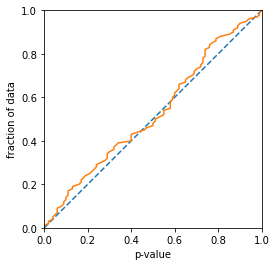

  1%|▊                                                                                 | 1/100 [00:02<04:07,  2.50s/it]

P-value: 0.89
Test stat: 0.15233601893397108
Null dist: [0.17132568031882778, 0.15336397505305432, 0.168520969972629, 0.1660492881486908, 0.13875184957920494]


  2%|█▋                                                                                | 2/100 [00:05<04:06,  2.51s/it]

P-value: 0.22
Test stat: 0.1682886286663312
Null dist: [0.1616279260008484, 0.16043826370081526, 0.1546923049010014, 0.1715255523450312, 0.15644686003751074]


  3%|██▍                                                                               | 3/100 [00:07<04:03,  2.51s/it]

P-value: 0.93
Test stat: 0.14862525853095043
Null dist: [0.17237290992153897, 0.15506002577247524, 0.14299576661217794, 0.17465457554345143, 0.17041528350087387]


  4%|███▎                                                                              | 4/100 [00:10<04:06,  2.57s/it]

P-value: 0.39
Test stat: 0.16409609427185268
Null dist: [0.1659400704654732, 0.16127260337778238, 0.15462890973357624, 0.16165726029461536, 0.17046182136442345]


  5%|████                                                                              | 5/100 [00:12<04:02,  2.55s/it]

P-value: 0.18
Test stat: 0.17061835117309676
Null dist: [0.16877649485330826, 0.1602162888186045, 0.15032746406130804, 0.1799820498008058, 0.1677533452010671]


  6%|████▉                                                                             | 6/100 [00:15<03:57,  2.52s/it]

P-value: 0.0
Test stat: 0.19325803431999322
Null dist: [0.1658372371165504, 0.1498317343754163, 0.17619140546610923, 0.16167162997815, 0.1673850972669063]


  7%|█████▋                                                                            | 7/100 [00:17<03:51,  2.48s/it]

P-value: 0.17
Test stat: 0.17166077826874626
Null dist: [0.16603187510929496, 0.15869341540805204, 0.15816620543796933, 0.17413498141519468, 0.17025691376639096]


  8%|██████▌                                                                           | 8/100 [00:19<03:46,  2.46s/it]

P-value: 0.03
Test stat: 0.17980114617256981
Null dist: [0.16060121815100425, 0.16336781696061364, 0.14865801166641257, 0.16151395524829437, 0.15172467099259934]


  9%|███████▍                                                                          | 9/100 [00:22<03:40,  2.43s/it]

P-value: 0.43
Test stat: 0.16776853375005574
Null dist: [0.1825305766874935, 0.15838357534295766, 0.16181439715154244, 0.16344386793952115, 0.15948026923367298]


 10%|████████                                                                         | 10/100 [00:24<03:40,  2.45s/it]

P-value: 0.94
Test stat: 0.14940046206481772
Null dist: [0.16518634622236195, 0.1659728759757263, 0.16255358700803002, 0.1546279322065015, 0.19527020522634886]


 11%|████████▉                                                                        | 11/100 [00:27<03:40,  2.48s/it]

P-value: 0.54
Test stat: 0.15636965201146436
Null dist: [0.18143189484444944, 0.14917923655578458, 0.17104652369275652, 0.15993038451756936, 0.14883125457938695]


 12%|█████████▋                                                                       | 12/100 [00:29<03:41,  2.51s/it]

P-value: 0.96
Test stat: 0.14686456657245306
Null dist: [0.17011199620925788, 0.16090715581773174, 0.17094875344648286, 0.16665171899222442, 0.15110076536774453]


 13%|██████████▌                                                                      | 13/100 [00:32<03:39,  2.52s/it]

P-value: 0.75
Test stat: 0.15549277382974425
Null dist: [0.17508390834293674, 0.15736962157074963, 0.16173099018284331, 0.16922055722625085, 0.15610791310801309]


 14%|███████████▎                                                                     | 14/100 [00:35<03:37,  2.53s/it]

P-value: 0.52
Test stat: 0.1614128355128791
Null dist: [0.16299790012748905, 0.15149137615569064, 0.14877811766448057, 0.17477220369014224, 0.15586387679416736]


 15%|████████████▏                                                                    | 15/100 [00:37<03:35,  2.54s/it]

P-value: 0.18
Test stat: 0.17347531656773452
Null dist: [0.16366507545375375, 0.1712213603698759, 0.16364435484555706, 0.1481379726813158, 0.16331934413145088]


 16%|████████████▉                                                                    | 16/100 [00:40<03:32,  2.53s/it]

P-value: 0.74
Test stat: 0.1535548186554493
Null dist: [0.17075040977742473, 0.15778995440136934, 0.1609640390314453, 0.15164561104029806, 0.16175961715282394]


 17%|█████████████▊                                                                   | 17/100 [00:42<03:32,  2.55s/it]

P-value: 0.09
Test stat: 0.1736843489314266
Null dist: [0.16611337558257855, 0.16842636208515793, 0.18819422625973947, 0.16181939115274724, 0.1631463151352298]


 18%|██████████████▌                                                                  | 18/100 [00:45<03:27,  2.53s/it]

P-value: 0.65
Test stat: 0.15470366725267692
Null dist: [0.17716579446193725, 0.16267784112841444, 0.1649427135369489, 0.14823656412436104, 0.14847894012629015]


 19%|███████████████▍                                                                 | 19/100 [00:47<03:25,  2.53s/it]

P-value: 0.03
Test stat: 0.1817010901818661
Null dist: [0.16988213724115675, 0.1687396584194103, 0.16779373003799058, 0.15916910390863281, 0.14885583834373262]


 20%|████████████████▏                                                                | 20/100 [00:50<03:23,  2.54s/it]

P-value: 0.59
Test stat: 0.15576905626202842
Null dist: [0.16161426095141407, 0.1549090250108529, 0.15705840973789975, 0.16246941378618762, 0.1710016195195927]


 21%|█████████████████                                                                | 21/100 [00:52<03:21,  2.55s/it]

P-value: 0.64
Test stat: 0.16236118791624854
Null dist: [0.16923269189711565, 0.16971076483528424, 0.15356966216418222, 0.15951316163744378, 0.17195517619467127]


 22%|█████████████████▊                                                               | 22/100 [00:55<03:18,  2.55s/it]

P-value: 0.57
Test stat: 0.160396047509056
Null dist: [0.14664647815786935, 0.1758329819082961, 0.16136120284119415, 0.14981535707961524, 0.17593412285692378]


 23%|██████████████████▋                                                              | 23/100 [00:57<03:15,  2.54s/it]

P-value: 0.49
Test stat: 0.16304700551513174
Null dist: [0.15862437666884543, 0.1688635426863978, 0.1578202991997466, 0.15737376081074284, 0.16436001860783822]


 24%|███████████████████▍                                                             | 24/100 [01:00<03:12,  2.54s/it]

P-value: 0.51
Test stat: 0.16590434209575733
Null dist: [0.15972782002568775, 0.15404321983271385, 0.1749373472494442, 0.16431976629762823, 0.1583033000641738]


 25%|████████████████████▎                                                            | 25/100 [01:03<03:10,  2.54s/it]

P-value: 0.3
Test stat: 0.1672946680802635
Null dist: [0.16262519423229416, 0.16912674558183194, 0.1701980536367691, 0.16841622791845556, 0.17299790944752425]


 26%|█████████████████████                                                            | 26/100 [01:05<03:07,  2.53s/it]

P-value: 0.19
Test stat: 0.175011747080705
Null dist: [0.15654607004672538, 0.16330147097240544, 0.1704896006477712, 0.1705995018993688, 0.1609978023267551]


 27%|█████████████████████▊                                                           | 27/100 [01:08<03:06,  2.55s/it]

P-value: 0.97
Test stat: 0.14678393790592315
Null dist: [0.17665290329481442, 0.17394273397453675, 0.16762453283324807, 0.15978298193908602, 0.15969449984085815]


 28%|██████████████████████▋                                                          | 28/100 [01:10<03:02,  2.54s/it]

P-value: 0.99
Test stat: 0.13623874191747787
Null dist: [0.15697588287893005, 0.16013234063964066, 0.16048841802670233, 0.1611938891296847, 0.15437072469174828]


 29%|███████████████████████▍                                                         | 29/100 [01:13<03:00,  2.54s/it]

P-value: 0.99
Test stat: 0.14771602351124802
Null dist: [0.1714745631438801, 0.1589504220219593, 0.16589542278557745, 0.16691260952291653, 0.16876169379234773]


 30%|████████████████████████▎                                                        | 30/100 [01:15<02:56,  2.52s/it]

P-value: 0.41
Test stat: 0.16778832572195623
Null dist: [0.16710078107959914, 0.16294595081457108, 0.17532473942676052, 0.15550710276353608, 0.16451583646594392]


 31%|█████████████████████████                                                        | 31/100 [01:18<02:51,  2.49s/it]

P-value: 0.67
Test stat: 0.1587932232921474
Null dist: [0.15908519525556453, 0.17019585145146865, 0.15591351310162815, 0.15867912297777287, 0.15639820460905474]


 32%|█████████████████████████▉                                                       | 32/100 [01:20<02:47,  2.47s/it]

P-value: 0.16
Test stat: 0.172026427015472
Null dist: [0.17115398875062637, 0.1545660338836644, 0.164543034244782, 0.15893600113752093, 0.1626487203091148]


 33%|██████████████████████████▋                                                      | 33/100 [01:22<02:43,  2.44s/it]

P-value: 0.13
Test stat: 0.17254054354430048
Null dist: [0.15163572548074633, 0.15631406549978522, 0.1618707367225689, 0.15774615703686012, 0.14820932414886534]


 34%|███████████████████████████▌                                                     | 34/100 [01:25<02:39,  2.42s/it]

P-value: 0.03
Test stat: 0.17860232625767625
Null dist: [0.1528595885990507, 0.1535024120761609, 0.15089834688791393, 0.16043775255944903, 0.16136789553646813]


 35%|████████████████████████████▎                                                    | 35/100 [01:27<02:41,  2.48s/it]

P-value: 0.15
Test stat: 0.1743333806865388
Null dist: [0.1657065151042263, 0.16084203513268258, 0.16565097081143687, 0.1590974406446437, 0.1696556532081296]


 36%|█████████████████████████████▏                                                   | 36/100 [01:30<02:36,  2.44s/it]

P-value: 0.66
Test stat: 0.15573487136655506
Null dist: [0.18020506393528157, 0.16849896061095415, 0.154377959437196, 0.15245343039585535, 0.1777662275509062]


 37%|█████████████████████████████▉                                                   | 37/100 [01:32<02:33,  2.44s/it]

P-value: 1.0
Test stat: 0.13958410495511142
Null dist: [0.15987225275096484, 0.170540796512347, 0.16168742712279638, 0.15957313953818542, 0.15452259198345142]


 38%|██████████████████████████████▊                                                  | 38/100 [01:35<02:30,  2.42s/it]

P-value: 0.46
Test stat: 0.15997571523377374
Null dist: [0.16853361845652748, 0.13757032379031853, 0.17954957684969552, 0.1617407722157106, 0.1574119615023578]


 39%|███████████████████████████████▌                                                 | 39/100 [01:37<02:27,  2.41s/it]

P-value: 0.15
Test stat: 0.17165666439699778
Null dist: [0.15612980420710676, 0.17894388089940905, 0.14865853361354286, 0.138653461089973, 0.15856541293124038]


 40%|████████████████████████████████▍                                                | 40/100 [01:39<02:25,  2.42s/it]

P-value: 0.32
Test stat: 0.1716910734502427
Null dist: [0.18312605219103806, 0.19116061830056963, 0.17523344520014594, 0.17291779883937897, 0.16999039194066834]


 41%|█████████████████████████████████▏                                               | 41/100 [01:42<02:23,  2.44s/it]

P-value: 0.82
Test stat: 0.15989658951416852
Null dist: [0.1770232014976717, 0.18147863250107643, 0.18198880318629607, 0.18923012844632225, 0.18734345132017527]


 42%|██████████████████████████████████                                               | 42/100 [01:44<02:23,  2.47s/it]

P-value: 0.06
Test stat: 0.18178126184888566
Null dist: [0.15257156000132677, 0.1619249037472521, 0.16763490484334265, 0.16287929566803816, 0.17642963849707072]


 43%|██████████████████████████████████▊                                              | 43/100 [01:47<02:20,  2.47s/it]

P-value: 0.65
Test stat: 0.1580234196060678
Null dist: [0.15406009089204653, 0.15916526521599272, 0.15532556194638725, 0.16933708920062318, 0.14645139935865825]


 44%|███████████████████████████████████▋                                             | 44/100 [01:49<02:19,  2.49s/it]

P-value: 0.15
Test stat: 0.1721023887062666
Null dist: [0.14189582174157755, 0.1619118476213336, 0.1689133397698791, 0.14812424492662812, 0.16876542992706245]


 45%|████████████████████████████████████▍                                            | 45/100 [01:52<02:16,  2.49s/it]

P-value: 0.96
Test stat: 0.14292427842152544
Null dist: [0.16015935750475996, 0.1681661156517975, 0.16781193422102159, 0.16658519369273994, 0.16116873255463082]


 46%|█████████████████████████████████████▎                                           | 46/100 [01:54<02:15,  2.52s/it]

P-value: 0.21
Test stat: 0.17623664477626577
Null dist: [0.1708796916227655, 0.1627305928004068, 0.16641851978938804, 0.1661728056010784, 0.16296643882970885]


 47%|██████████████████████████████████████                                           | 47/100 [01:57<02:13,  2.53s/it]

P-value: 0.46
Test stat: 0.16702318597271282
Null dist: [0.15587598630142574, 0.15226208288310217, 0.1671330229579302, 0.16699243329938818, 0.16342579554169845]


 48%|██████████████████████████████████████▉                                          | 48/100 [02:00<02:10,  2.51s/it]

P-value: 0.3
Test stat: 0.17148882313489133
Null dist: [0.1721665181253591, 0.16142552464469362, 0.15576611693465447, 0.17059961986672523, 0.1408817321562328]


 49%|███████████████████████████████████████▋                                         | 49/100 [02:03<02:16,  2.68s/it]

P-value: 0.35
Test stat: 0.16427499041803428
Null dist: [0.14782031351262825, 0.18286066892294062, 0.16340392556218486, 0.16321388218654764, 0.16751380975714736]


 50%|████████████████████████████████████████▌                                        | 50/100 [02:05<02:16,  2.73s/it]

P-value: 0.9
Test stat: 0.14835288100887278
Null dist: [0.1605844004295136, 0.1786652978151695, 0.14922471484681987, 0.16417589381514297, 0.15235237632814103]


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:08<02:14,  2.74s/it]

P-value: 0.39
Test stat: 0.1680054511489638
Null dist: [0.16091014603050535, 0.16962331161939548, 0.15902337364478725, 0.16773685605517452, 0.15595980524990904]


 52%|██████████████████████████████████████████                                       | 52/100 [02:11<02:13,  2.78s/it]

P-value: 0.55
Test stat: 0.15541434501130258
Null dist: [0.14268069971866026, 0.1857523918377989, 0.15877058960765744, 0.14632121341367965, 0.15111182272641488]


 53%|██████████████████████████████████████████▉                                      | 53/100 [02:14<02:17,  2.93s/it]

P-value: 0.13
Test stat: 0.17181031658991253
Null dist: [0.16192092847112038, 0.15268795520695821, 0.1686111373299818, 0.1603489838883302, 0.16075226757123195]


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:18<02:19,  3.04s/it]

P-value: 0.47
Test stat: 0.16813249133656583
Null dist: [0.16268658835353877, 0.1758213168127929, 0.15981453585763794, 0.1693165283211624, 0.16493432494107663]


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:22<02:35,  3.45s/it]

P-value: 0.63
Test stat: 0.16241317284699197
Null dist: [0.15579107561117067, 0.17275920390715138, 0.16691927446030552, 0.16518225704731682, 0.16860000710423328]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:26<02:33,  3.49s/it]

P-value: 0.9
Test stat: 0.15142790060731248
Null dist: [0.15313736531383315, 0.15209247266107706, 0.1439213551404478, 0.16066462212060917, 0.1609559983478539]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:30<02:35,  3.61s/it]

P-value: 0.48
Test stat: 0.16663865036135006
Null dist: [0.16062661940500378, 0.1787177601721257, 0.16184349616006488, 0.15025461718113564, 0.15649039883345262]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:32<02:21,  3.36s/it]

P-value: 0.82
Test stat: 0.15714539129048588
Null dist: [0.17156677961419642, 0.16005090570352887, 0.1595540120461475, 0.15689957465695437, 0.1517683994826292]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:35<02:09,  3.16s/it]

P-value: 0.09
Test stat: 0.17334148873419086
Null dist: [0.1683525474072669, 0.15081360563256097, 0.14270150888332656, 0.16849331708172666, 0.16129377698715164]


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:37<01:56,  2.92s/it]

P-value: 0.29
Test stat: 0.16888459522140575
Null dist: [0.15877218690548367, 0.18618655357368397, 0.16505122004939354, 0.17351890499622302, 0.15339018795227588]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:40<01:52,  2.89s/it]

P-value: 0.92
Test stat: 0.149934917363861
Null dist: [0.1471989053049072, 0.1530399758059543, 0.15829446694467197, 0.161881318796808, 0.16803944057253284]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [02:43<01:46,  2.80s/it]

P-value: 0.38
Test stat: 0.1696557974151076
Null dist: [0.16322227848072435, 0.16622756392887472, 0.1690679552488541, 0.15296646733467312, 0.1746766104423646]


 63%|███████████████████████████████████████████████████                              | 63/100 [02:45<01:42,  2.76s/it]

P-value: 0.78
Test stat: 0.15654829144309867
Null dist: [0.17515121288784208, 0.17990371185580334, 0.1528939239075836, 0.17919833912348437, 0.14823096032684047]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:48<01:41,  2.82s/it]

P-value: 0.89
Test stat: 0.15026893630368954
Null dist: [0.16982951412587077, 0.16847137315104366, 0.1693658216283097, 0.1432879990162348, 0.15838839033594687]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [02:51<01:38,  2.82s/it]

P-value: 0.0
Test stat: 0.1856261058728398
Null dist: [0.1479764909921737, 0.18050805122928504, 0.1630895173762651, 0.1629050614350408, 0.1671790463366889]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [02:54<01:35,  2.80s/it]

P-value: 0.73
Test stat: 0.15424191795718512
Null dist: [0.16590582182467772, 0.1480867987434864, 0.16727879102332643, 0.16470841004165704, 0.16391247087632088]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [02:56<01:27,  2.65s/it]

P-value: 0.75
Test stat: 0.1581611374195162
Null dist: [0.16679068524423213, 0.16637279900553337, 0.17841962203805384, 0.15593600303495736, 0.15324811520092452]


 68%|███████████████████████████████████████████████████████                          | 68/100 [02:59<01:23,  2.60s/it]

P-value: 0.95
Test stat: 0.1519388215048908
Null dist: [0.1737705866863004, 0.15017602549019915, 0.1604017474061712, 0.17035293133244322, 0.15825767130348267]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:01<01:18,  2.52s/it]

P-value: 0.62
Test stat: 0.16032888488758135
Null dist: [0.1725380607689344, 0.17758150864278321, 0.14817386988370917, 0.1555862801840524, 0.1658649692623696]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [03:04<01:14,  2.49s/it]

P-value: 0.85
Test stat: 0.1503957640048572
Null dist: [0.13813990274515187, 0.16052461927940398, 0.16015506178939154, 0.16312058025319087, 0.16959702626912443]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [03:06<01:15,  2.61s/it]

P-value: 0.77
Test stat: 0.1621484690702344
Null dist: [0.15759035794645282, 0.16833028227868208, 0.16888918261211094, 0.18785949414414116, 0.1618150295209262]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [03:09<01:11,  2.57s/it]

P-value: 0.41
Test stat: 0.1647651703473022
Null dist: [0.15748844023971886, 0.1464982610949035, 0.155699425429753, 0.15974843136073102, 0.14975187768197817]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [03:12<01:11,  2.63s/it]

P-value: 0.52
Test stat: 0.16839896975449575
Null dist: [0.15990384804153535, 0.1673767438471676, 0.1614193461271496, 0.1846359882959685, 0.17228718206696914]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [03:14<01:07,  2.61s/it]

P-value: 0.6
Test stat: 0.1539733953770428
Null dist: [0.16592850391283454, 0.14756636137997314, 0.15041828999200568, 0.14988346918681794, 0.16833423768512734]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [03:18<01:11,  2.87s/it]

P-value: 0.68
Test stat: 0.15882823333798757
Null dist: [0.1572802848857654, 0.1889587872769637, 0.17250860095282283, 0.1563666185227387, 0.16169563803825127]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [03:21<01:13,  3.06s/it]

P-value: 0.06
Test stat: 0.17927053140216298
Null dist: [0.15997311828301708, 0.1683523378955598, 0.16576376777011426, 0.17484531100569056, 0.1588879239031078]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [03:24<01:11,  3.11s/it]

P-value: 0.77
Test stat: 0.15927014794147776
Null dist: [0.15314189058441874, 0.1725846257071153, 0.1677613464863763, 0.16223650888111485, 0.15870350905098718]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [03:28<01:10,  3.23s/it]

P-value: 0.47
Test stat: 0.16376300669857713
Null dist: [0.158351828516772, 0.17457452211207747, 0.16662407475532182, 0.16586370223774405, 0.15281938001866457]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [03:31<01:07,  3.22s/it]

P-value: 0.21
Test stat: 0.1718302596934459
Null dist: [0.1536241823113068, 0.17286971058592315, 0.1524501118303434, 0.1504811554485217, 0.16197872869060037]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [03:34<01:03,  3.18s/it]

P-value: 0.41
Test stat: 0.1690254925705279
Null dist: [0.16912340833929407, 0.17268238004068426, 0.16067006021248142, 0.165589403178792, 0.17080929301430692]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [03:37<00:58,  3.08s/it]

P-value: 0.22
Test stat: 0.17078720305038042
Null dist: [0.1662943304351906, 0.16463980843381631, 0.16822662576883984, 0.181791534711907, 0.16307015865572616]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [03:40<00:54,  3.02s/it]

P-value: 0.64
Test stat: 0.16527210125642122
Null dist: [0.15299796711791613, 0.15704780893781245, 0.16228838904691312, 0.17398881041384584, 0.17607567099828247]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [03:44<00:57,  3.36s/it]

P-value: 0.89
Test stat: 0.14793280354298033
Null dist: [0.1560484407295719, 0.16471315411964937, 0.15118133190508054, 0.15760259626679862, 0.17274903650431117]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [03:49<01:00,  3.75s/it]

P-value: 0.64
Test stat: 0.15946832344327289
Null dist: [0.1664462499408963, 0.17648806109724435, 0.16906843437602814, 0.18021720513193418, 0.15767913639193554]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [03:51<00:51,  3.42s/it]

P-value: 0.5
Test stat: 0.16411242850737418
Null dist: [0.17379576142814646, 0.16618020959199264, 0.15573035151052428, 0.15826505324376627, 0.15200013595376038]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [03:54<00:43,  3.14s/it]

P-value: 0.93
Test stat: 0.15164961277006128
Null dist: [0.15930866101099705, 0.1664798148884975, 0.16341183194651665, 0.1693555662917452, 0.15411277829661219]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [03:56<00:38,  2.96s/it]

P-value: 0.17
Test stat: 0.17074273120549643
Null dist: [0.16533365734894434, 0.16720170131761125, 0.14844515987065332, 0.1736498760369033, 0.16535958284681362]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [03:59<00:33,  2.78s/it]

P-value: 0.39
Test stat: 0.1644437651716224
Null dist: [0.1706742767615157, 0.15591889717764462, 0.15978438513236115, 0.1688220999608433, 0.16734639488798364]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [04:02<00:30,  2.79s/it]

P-value: 0.4
Test stat: 0.16127061955077993
Null dist: [0.15657715596754507, 0.15548079730308761, 0.15895387486331847, 0.15179795417418274, 0.1550555643949444]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [04:04<00:27,  2.76s/it]

P-value: 0.11
Test stat: 0.17648036294557978
Null dist: [0.15650737189711328, 0.1476227764157002, 0.16840487240044233, 0.16636413651652404, 0.15431485872326256]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [04:07<00:23,  2.62s/it]

P-value: 0.42
Test stat: 0.16340004591389812
Null dist: [0.16261973491796744, 0.16658414229469964, 0.16034103356492546, 0.16764366249433527, 0.16897177601287738]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [04:09<00:21,  2.72s/it]

P-value: 0.35
Test stat: 0.1660635462424066
Null dist: [0.15403071511596966, 0.18059336351330768, 0.17823198371527105, 0.15706267431629617, 0.16150516662505088]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [04:12<00:18,  2.66s/it]

P-value: 0.57
Test stat: 0.160588253336728
Null dist: [0.16659592641657783, 0.15686300526851105, 0.15716279100664754, 0.17206010608277966, 0.1788626985507289]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [04:15<00:16,  2.80s/it]

P-value: 0.02
Test stat: 0.18114312424756207
Null dist: [0.17400529387306363, 0.1762103734597099, 0.15743279455277792, 0.16568822377974524, 0.1699151760616715]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [04:18<00:14,  2.85s/it]

P-value: 0.53
Test stat: 0.16553228696166755
Null dist: [0.18311526046603532, 0.15553169940760192, 0.1592982255550932, 0.16228878144190584, 0.16738999916706698]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [04:21<00:10,  2.74s/it]

P-value: 0.41
Test stat: 0.15837796792487868
Null dist: [0.1515980409909352, 0.1703777999341185, 0.17018102522227496, 0.1464619572492657, 0.15652529300821882]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [04:23<00:07,  2.65s/it]

P-value: 0.47
Test stat: 0.16416772154976322
Null dist: [0.16914419627009214, 0.15706522503649778, 0.15703578436733223, 0.16166992600203645, 0.17014060401187447]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [04:26<00:05,  2.70s/it]

P-value: 0.79
Test stat: 0.15332593366249403
Null dist: [0.15395428528786126, 0.1610666656642884, 0.18176558339570836, 0.1597470241235518, 0.16377006275513128]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:29<00:02,  2.80s/it]

P-value: 0.62
Test stat: 0.16229046458882945
Null dist: [0.1724578935986758, 0.16178477122146406, 0.1813733831671417, 0.14720927064552713, 0.1657201853171053]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:32<00:00,  2.72s/it]

P-value: 0.11
Test stat: 0.16642531610263678
Null dist: [0.1568792662906182, 0.15603293515039118, 0.15142376757495357, 0.14946644393909503, 0.1655167927837271]


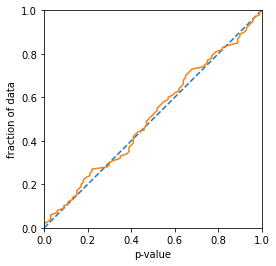

  1%|▊                                                                                 | 1/100 [00:03<05:34,  3.38s/it]

P-value: 0.71
Test stat: 0.16060980754560195
Null dist: [0.15756391934317227, 0.1657074238586358, 0.1738981883209727, 0.16111332536177936, 0.18004906012069455]


  2%|█▋                                                                                | 2/100 [00:07<05:39,  3.46s/it]

P-value: 0.64
Test stat: 0.16268084517475712
Null dist: [0.15229405619230219, 0.16449013544347257, 0.1641644520044414, 0.15892355597561436, 0.1507121650282608]


  3%|██▍                                                                               | 3/100 [00:10<05:30,  3.41s/it]

P-value: 0.78
Test stat: 0.15632497684942592
Null dist: [0.18518925611493786, 0.16787285209891678, 0.15343671212342191, 0.16731277003127887, 0.17550609132141004]


  4%|███▎                                                                              | 4/100 [00:13<05:24,  3.38s/it]

P-value: 0.09
Test stat: 0.17822389979842712
Null dist: [0.15968691682904945, 0.17013150922440157, 0.17125285784408395, 0.17929036946945587, 0.1758780339316045]


  5%|████                                                                              | 5/100 [00:16<05:16,  3.34s/it]

P-value: 0.62
Test stat: 0.15981370907377224
Null dist: [0.16225214630725893, 0.15866815922942268, 0.15476696880709329, 0.1771146075181702, 0.15616522759964402]


  6%|████▉                                                                             | 6/100 [00:20<05:21,  3.42s/it]

P-value: 0.46
Test stat: 0.16448145294761463
Null dist: [0.17222158431782764, 0.1597596045702525, 0.16784508226133088, 0.16233847468662366, 0.1512825688539412]


  7%|█████▋                                                                            | 7/100 [00:24<05:38,  3.64s/it]

P-value: 0.83
Test stat: 0.15354346065881297
Null dist: [0.15270496193861105, 0.1660801860379355, 0.17163817640567447, 0.15820935011127069, 0.1542890397313107]


  8%|██████▌                                                                           | 8/100 [00:28<05:34,  3.63s/it]

P-value: 0.01
Test stat: 0.1927006828917308
Null dist: [0.1690513371880723, 0.16140587934792783, 0.18043594968526155, 0.1753741596132382, 0.15852083143508755]


  9%|███████▍                                                                          | 9/100 [00:31<05:25,  3.57s/it]

P-value: 0.49
Test stat: 0.1602451106670566
Null dist: [0.1593833385506629, 0.1686054634605172, 0.16629338512536618, 0.16986649772179052, 0.15015329986789927]


 10%|████████                                                                         | 10/100 [00:34<05:14,  3.49s/it]

P-value: 0.86
Test stat: 0.15328444429001187
Null dist: [0.1578600220642009, 0.17864243035838856, 0.1629961411872083, 0.16379992550846845, 0.16619154099748434]


 11%|████████▉                                                                        | 11/100 [00:38<05:11,  3.49s/it]

P-value: 0.9
Test stat: 0.1512789694662422
Null dist: [0.15293540816695006, 0.14522850973066603, 0.1706490094934192, 0.16391620157726283, 0.1445069195418197]


 12%|█████████▋                                                                       | 12/100 [00:41<05:01,  3.43s/it]

P-value: 0.73
Test stat: 0.15746947819210766
Null dist: [0.15188651378825957, 0.16409852374243417, 0.15980400533982042, 0.164887069631645, 0.17394437786537387]


 13%|██████████▌                                                                      | 13/100 [00:45<04:55,  3.39s/it]

P-value: 0.34
Test stat: 0.17137353991396842
Null dist: [0.1666245086845105, 0.16707513405076357, 0.17096724006789565, 0.17304379489665744, 0.17769626409540396]


 14%|███████████▎                                                                     | 14/100 [00:48<04:51,  3.39s/it]

P-value: 0.0
Test stat: 0.18337384319818462
Null dist: [0.1565772639865468, 0.15476458388817582, 0.1593016133625742, 0.16535526337989448, 0.17045532824714849]


 15%|████████████▏                                                                    | 15/100 [00:51<04:46,  3.37s/it]

P-value: 0.12
Test stat: 0.17513737342762226
Null dist: [0.15618278776332306, 0.17214689553595974, 0.1716973284622778, 0.16183972397157564, 0.1740245426031478]


 16%|████████████▉                                                                    | 16/100 [00:55<04:40,  3.34s/it]

P-value: 0.63
Test stat: 0.15693990833088944
Null dist: [0.16852619079103448, 0.1447872774489991, 0.16473316177677721, 0.15877574487515012, 0.15482109677749656]


 17%|█████████████▊                                                                   | 17/100 [00:58<04:36,  3.34s/it]

P-value: 0.47
Test stat: 0.1659866402667648
Null dist: [0.16539115013446326, 0.17090274765847635, 0.16345285906101759, 0.16649673006529508, 0.1704108609982532]


 18%|██████████████▌                                                                  | 18/100 [01:01<04:32,  3.32s/it]

P-value: 0.9
Test stat: 0.15589962751361752
Null dist: [0.16720259510113045, 0.15561433434777627, 0.16020598648214102, 0.17050455132900166, 0.17145688348514943]


 19%|███████████████▍                                                                 | 19/100 [01:05<04:29,  3.32s/it]

P-value: 0.27
Test stat: 0.17018125354931457
Null dist: [0.1677756930668306, 0.16519916407455926, 0.166267458339308, 0.16922346663546617, 0.16124649432910143]


 20%|████████████████▏                                                                | 20/100 [01:08<04:35,  3.45s/it]

P-value: 0.03
Test stat: 0.17543908235581185
Null dist: [0.1571713162150491, 0.15372304929128044, 0.1502442808638419, 0.14776233234503855, 0.15755347151999355]


 21%|█████████████████                                                                | 21/100 [01:13<05:00,  3.80s/it]

P-value: 0.71
Test stat: 0.154919329762075
Null dist: [0.16249163740757155, 0.1668453927871777, 0.17344755405772805, 0.15960788989911168, 0.16968193062899262]


 22%|█████████████████▊                                                               | 22/100 [01:16<04:49,  3.71s/it]

P-value: 0.55
Test stat: 0.1611921973282049
Null dist: [0.16852629155541998, 0.1607709007977901, 0.16786132262377795, 0.17090276183390074, 0.15102743394724638]


 23%|██████████████████▋                                                              | 23/100 [01:20<04:34,  3.56s/it]

P-value: 0.0
Test stat: 0.17821259632423592
Null dist: [0.17037949678095254, 0.14749902717464425, 0.1629361083687867, 0.14076634936560972, 0.1422752373235484]


 24%|███████████████████▍                                                             | 24/100 [01:23<04:22,  3.45s/it]

P-value: 0.26
Test stat: 0.17065208857643788
Null dist: [0.1537736110426392, 0.14897077905500955, 0.15981106201608275, 0.163801009672213, 0.18007032438016712]


 25%|████████████████████▎                                                            | 25/100 [01:26<04:15,  3.41s/it]

P-value: 0.96
Test stat: 0.1489931937546386
Null dist: [0.17179600732064215, 0.17073362898699584, 0.1751958407783235, 0.1627638265540572, 0.15038288441554482]


 26%|█████████████████████                                                            | 26/100 [01:29<04:09,  3.37s/it]

P-value: 0.59
Test stat: 0.16335462175392956
Null dist: [0.1542741143121772, 0.1875372878523256, 0.15133608290203981, 0.1733898951297821, 0.1601351082555038]


 27%|█████████████████████▊                                                           | 27/100 [01:33<04:06,  3.37s/it]

P-value: 0.08
Test stat: 0.17729873461068346
Null dist: [0.1543044188658852, 0.17226588533230802, 0.16991485773329684, 0.1753013691726213, 0.1781357010000495]


 28%|██████████████████████▋                                                          | 28/100 [01:36<04:02,  3.36s/it]

P-value: 0.91
Test stat: 0.15659815251030262
Null dist: [0.18386166878984278, 0.16836653559381642, 0.15576846165501124, 0.16713750363039637, 0.170560862701308]


 29%|███████████████████████▍                                                         | 29/100 [01:40<04:04,  3.44s/it]

P-value: 0.29
Test stat: 0.16986796377017777
Null dist: [0.17246436946094978, 0.1650031459962159, 0.1610294183391654, 0.15532896551238795, 0.17645909510019986]


 30%|████████████████████████▎                                                        | 30/100 [01:43<04:02,  3.46s/it]

P-value: 0.09
Test stat: 0.1720410289395652
Null dist: [0.15715637312986197, 0.16176256246772946, 0.1700179796202026, 0.1597933470750309, 0.15468227758949615]


 31%|█████████████████████████                                                        | 31/100 [01:47<04:10,  3.62s/it]

P-value: 0.07
Test stat: 0.17348122541135091
Null dist: [0.1680249239516367, 0.16207840976097765, 0.14723853535180242, 0.15541811020864027, 0.141780169382425]


 32%|█████████████████████████▉                                                       | 32/100 [01:51<04:08,  3.65s/it]

P-value: 0.63
Test stat: 0.16389124336173744
Null dist: [0.1492321517536077, 0.16153468737142584, 0.16317321951636432, 0.16739735862094407, 0.176446230724854]


 33%|██████████████████████████▋                                                      | 33/100 [01:54<03:56,  3.53s/it]

P-value: 0.28
Test stat: 0.16634545518130506
Null dist: [0.14851242382057084, 0.16272374211230933, 0.15279637901669074, 0.1626475675803919, 0.1634464076636164]


 34%|███████████████████████████▌                                                     | 34/100 [01:57<03:45,  3.42s/it]

P-value: 0.19
Test stat: 0.16987039131099058
Null dist: [0.1634655299688319, 0.1635273562927143, 0.1533627413285037, 0.16598077396850308, 0.16309575826438272]


 35%|████████████████████████████▎                                                    | 35/100 [02:01<03:47,  3.50s/it]

P-value: 0.62
Test stat: 0.16069210039745185
Null dist: [0.13657366152487405, 0.17006913770594745, 0.1558478550138339, 0.1530785960076514, 0.16423515607007766]


 36%|█████████████████████████████▏                                                   | 36/100 [02:04<03:38,  3.42s/it]

P-value: 0.96
Test stat: 0.14936450670171486
Null dist: [0.14254053802646938, 0.16550253552592264, 0.15256172887571873, 0.16874425779314206, 0.14944509691634278]


 37%|█████████████████████████████▉                                                   | 37/100 [02:07<03:31,  3.35s/it]

P-value: 0.73
Test stat: 0.15483348326825241
Null dist: [0.1542877105949586, 0.142401954509204, 0.16507299013771437, 0.15311899825124953, 0.1580255390004337]


 38%|██████████████████████████████▊                                                  | 38/100 [02:11<03:31,  3.40s/it]

P-value: 0.74
Test stat: 0.1581783185069362
Null dist: [0.14793914969495725, 0.17312173182465584, 0.1647002084016984, 0.16816417587342403, 0.16711156382552605]


 39%|███████████████████████████████▌                                                 | 39/100 [02:14<03:26,  3.38s/it]

P-value: 0.91
Test stat: 0.15004368448043426
Null dist: [0.16876230518974145, 0.1669747746471485, 0.1542953793376277, 0.15445307460710145, 0.17466932714014494]


 40%|████████████████████████████████▍                                                | 40/100 [02:18<03:22,  3.37s/it]

P-value: 0.64
Test stat: 0.16060791477681047
Null dist: [0.15303766268828733, 0.16143794803284517, 0.16032406074456562, 0.1595003500181299, 0.15795848613597574]


 41%|█████████████████████████████████▏                                               | 41/100 [02:21<03:20,  3.40s/it]

P-value: 0.07
Test stat: 0.1737536187056945
Null dist: [0.15844647471843099, 0.16780196147300364, 0.16217009758469791, 0.16538932430982933, 0.16383757486493167]


 42%|██████████████████████████████████                                               | 42/100 [02:25<03:17,  3.41s/it]

P-value: 0.97
Test stat: 0.14709842428534192
Null dist: [0.1538249528091029, 0.15285586229049153, 0.15766584250362892, 0.1546523470816712, 0.16278154814462698]


 43%|██████████████████████████████████▊                                              | 43/100 [02:28<03:10,  3.35s/it]

P-value: 0.54
Test stat: 0.16404575743062355
Null dist: [0.17801160682060735, 0.16831284656196055, 0.1652678829883314, 0.1565569782323406, 0.18285075661533623]


 44%|███████████████████████████████████▋                                             | 44/100 [02:31<03:07,  3.35s/it]

P-value: 0.74
Test stat: 0.1629654969053259
Null dist: [0.1548067401686538, 0.1734120141179455, 0.16058763609878457, 0.16222871618110513, 0.17319509434582314]


 45%|████████████████████████████████████▍                                            | 45/100 [02:34<03:03,  3.34s/it]

P-value: 0.75
Test stat: 0.1642547476271069
Null dist: [0.1831698515826059, 0.15325325977677018, 0.16456333836055603, 0.16531722405587246, 0.1581584716148441]


 46%|█████████████████████████████████████▎                                           | 46/100 [02:38<03:01,  3.35s/it]

P-value: 0.09
Test stat: 0.17450765891861408
Null dist: [0.1727287441462343, 0.1515819859734293, 0.15147599787363164, 0.15801571915863732, 0.16987415380909288]


 47%|██████████████████████████████████████                                           | 47/100 [02:41<02:57,  3.35s/it]

P-value: 0.99
Test stat: 0.1439464590742281
Null dist: [0.17414550881124224, 0.16623913240823796, 0.1552254776452141, 0.16652411043143844, 0.14618042206099113]


 48%|██████████████████████████████████████▉                                          | 48/100 [02:44<02:51,  3.30s/it]

P-value: 0.8
Test stat: 0.15214867309204272
Null dist: [0.16884745336612483, 0.16850273547951033, 0.15567738919451402, 0.1579981437621264, 0.16338184471631612]


 49%|███████████████████████████████████████▋                                         | 49/100 [02:48<02:46,  3.27s/it]

P-value: 0.47
Test stat: 0.1618327408653869
Null dist: [0.1579780547011499, 0.16795944236668348, 0.16739187693701696, 0.15508647179329738, 0.1717335149057606]


 50%|████████████████████████████████████████▌                                        | 50/100 [02:51<02:42,  3.25s/it]

P-value: 0.1
Test stat: 0.1708266327050667
Null dist: [0.1681010935137397, 0.15390512506430531, 0.17583750384108865, 0.16904559880785242, 0.1672568413236032]


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:54<02:38,  3.24s/it]

P-value: 0.49
Test stat: 0.16165099340696454
Null dist: [0.15839988904857782, 0.15496970274749167, 0.17294661645039233, 0.1566515259109187, 0.14826874521134026]


 52%|██████████████████████████████████████████                                       | 52/100 [02:57<02:37,  3.28s/it]

P-value: 0.29
Test stat: 0.16618025154131233
Null dist: [0.16151241642090353, 0.15051927700227774, 0.16755832756723343, 0.1709155210281622, 0.1711879500165876]


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:00<02:32,  3.25s/it]

P-value: 0.19
Test stat: 0.16982066427604747
Null dist: [0.15753594574840424, 0.16016523720676634, 0.17337557665117098, 0.16318581023265533, 0.1689944142068478]


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:04<02:30,  3.28s/it]

P-value: 0.66
Test stat: 0.16453431497302906
Null dist: [0.17236177402953212, 0.16865730089170294, 0.16131493229520133, 0.1672408724309531, 0.16926328919045974]


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:07<02:30,  3.35s/it]

P-value: 0.55
Test stat: 0.16142481985087098
Null dist: [0.1591447310251075, 0.17665173265263, 0.16993747953923588, 0.15595467957108444, 0.15028449911850628]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:11<02:25,  3.31s/it]

P-value: 0.95
Test stat: 0.15279933470745155
Null dist: [0.15680096808033817, 0.17472808746026625, 0.17047308575284625, 0.16503810899849702, 0.17139378933739235]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:14<02:19,  3.25s/it]

P-value: 0.62
Test stat: 0.1606069345900334
Null dist: [0.17028462675172873, 0.1717080472241055, 0.16637831252163426, 0.15871055020233416, 0.1848466145002149]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:17<02:15,  3.22s/it]

P-value: 0.0
Test stat: 0.18567068962367161
Null dist: [0.16583054760077187, 0.14395583569996906, 0.16714817713917574, 0.15631458390674102, 0.17285479908980295]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:20<02:10,  3.19s/it]

P-value: 0.45
Test stat: 0.16490518486796224
Null dist: [0.17385879476540145, 0.17317405492171312, 0.15813714922219402, 0.1607121600294178, 0.16472505774082613]


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:23<02:06,  3.16s/it]

P-value: 0.62
Test stat: 0.15900513063494048
Null dist: [0.16206023761251698, 0.16607528685060424, 0.14676763511982005, 0.14418289857618605, 0.15323722120451166]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:26<02:01,  3.12s/it]

P-value: 0.23
Test stat: 0.16817736759433688
Null dist: [0.16919190341276802, 0.1707693372072534, 0.15602978938386047, 0.15077115174886813, 0.16492645721182786]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:29<01:58,  3.11s/it]

P-value: 0.42
Test stat: 0.16136825333896887
Null dist: [0.15990898111192564, 0.16368419300799952, 0.151496037989169, 0.15889541095837, 0.15909980441320415]


 63%|███████████████████████████████████████████████████                              | 63/100 [03:32<01:56,  3.15s/it]

P-value: 0.31
Test stat: 0.16806143760630177
Null dist: [0.15799687920570538, 0.15918855694178757, 0.15041255479599225, 0.15815757181287693, 0.16373592373505785]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:36<01:53,  3.16s/it]

P-value: 0.57
Test stat: 0.16073226553672537
Null dist: [0.1566262116752919, 0.16675868952686612, 0.15480748804049171, 0.16993435461757012, 0.15442395437833267]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:39<01:51,  3.19s/it]

P-value: 0.04
Test stat: 0.1705746582692349
Null dist: [0.1496651776671316, 0.15211647003817919, 0.14847895781938492, 0.1470542089747141, 0.1763613435515936]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:42<01:48,  3.19s/it]

P-value: 0.72
Test stat: 0.15929382597078645
Null dist: [0.16909034674062762, 0.16142250923591717, 0.17616246203093477, 0.17200568593441512, 0.16589314552964252]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:45<01:43,  3.14s/it]

P-value: 0.92
Test stat: 0.15156313892555584
Null dist: [0.1644293167278288, 0.17155446569950106, 0.16187879775896175, 0.1685053763705575, 0.16981191464937662]


 68%|███████████████████████████████████████████████████████                          | 68/100 [03:48<01:39,  3.12s/it]

P-value: 0.64
Test stat: 0.1624835421422104
Null dist: [0.17488377368874874, 0.15818153568931215, 0.17553382420201868, 0.15166776173700958, 0.1664953703328852]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:51<01:36,  3.11s/it]

P-value: 0.79
Test stat: 0.15906935907489506
Null dist: [0.1705762434984821, 0.17353588495090055, 0.15607496130940213, 0.16087724320057206, 0.16736708310822013]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [03:54<01:33,  3.12s/it]

P-value: 0.51
Test stat: 0.16571199601941355
Null dist: [0.18114891482121132, 0.1595755023335862, 0.1611201383549472, 0.1672062279853257, 0.16312301958996644]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [03:58<01:31,  3.14s/it]

P-value: 0.4
Test stat: 0.160469944865951
Null dist: [0.1715435557659324, 0.1555800998940784, 0.16353289972537033, 0.15657280065346835, 0.15735381397817094]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:01<01:27,  3.12s/it]

P-value: 0.87
Test stat: 0.15228034582305483
Null dist: [0.1620453667284073, 0.17449486001302184, 0.1535274684299761, 0.15970313680270853, 0.16589913415591995]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:04<01:24,  3.13s/it]

P-value: 0.72
Test stat: 0.15638805910151388
Null dist: [0.16707752848653035, 0.15673118525462448, 0.16399613374031397, 0.15536389074759271, 0.16506663103139707]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [04:07<01:21,  3.13s/it]

P-value: 0.84
Test stat: 0.15725010636761616
Null dist: [0.17365974844182652, 0.15597334933196583, 0.17440369650844434, 0.17130107535268613, 0.1627259874258492]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [04:10<01:18,  3.14s/it]

P-value: 0.38
Test stat: 0.16865031912285477
Null dist: [0.1674185459627422, 0.1601351181658821, 0.17038347655572506, 0.1660954999621762, 0.153757880887347]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [04:13<01:15,  3.14s/it]

P-value: 0.82
Test stat: 0.15781522716367125
Null dist: [0.16981820029963635, 0.1687197828092749, 0.15707677018725108, 0.15830673619377378, 0.16538326937831704]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [04:16<01:11,  3.12s/it]

P-value: 0.59
Test stat: 0.16064326434102794
Null dist: [0.16665041732745467, 0.1587411283327953, 0.1632387846648914, 0.15753621850091226, 0.16041056547869437]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [04:19<01:08,  3.11s/it]

P-value: 0.81
Test stat: 0.15357341646552647
Null dist: [0.15469593237165413, 0.16687581336773472, 0.16388977140487293, 0.1514965531918161, 0.17473932610484033]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [04:23<01:06,  3.18s/it]

P-value: 0.39
Test stat: 0.16271303308321683
Null dist: [0.15343946248986262, 0.17401119600519743, 0.17645083020341557, 0.15335610422800006, 0.14376129066831778]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [04:26<01:03,  3.18s/it]

P-value: 0.8
Test stat: 0.15469843957011842
Null dist: [0.1647926850842808, 0.15276613522009796, 0.17272598453622323, 0.15180565790387668, 0.16814065415742763]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:29<01:01,  3.23s/it]

P-value: 0.25
Test stat: 0.17014163850887132
Null dist: [0.15459693739866032, 0.15355643896149862, 0.1673942487173935, 0.1694491543474671, 0.16517934694217506]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:32<00:58,  3.24s/it]

P-value: 0.99
Test stat: 0.1473528673726786
Null dist: [0.16713177631979848, 0.15914409774994598, 0.17559449294395646, 0.16654907782919037, 0.16335802343328398]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [04:36<00:54,  3.23s/it]

P-value: 0.19
Test stat: 0.17043209001650106
Null dist: [0.16891540235039348, 0.1789132619247018, 0.16077839364101454, 0.16970496481310293, 0.17354615405245133]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [04:39<00:52,  3.26s/it]

P-value: 0.93
Test stat: 0.14973408391754328
Null dist: [0.1621969933914722, 0.1629786042982605, 0.16565010707460814, 0.16251030956884738, 0.1724665135920821]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [04:42<00:48,  3.25s/it]

P-value: 0.71
Test stat: 0.15894047188585303
Null dist: [0.1535028617707862, 0.16371381069600166, 0.17442831516513913, 0.16539473355062362, 0.16038758906604078]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [04:45<00:45,  3.22s/it]

P-value: 0.84
Test stat: 0.14947133915385302
Null dist: [0.1673946812905367, 0.16453955122461839, 0.1555450733771806, 0.15305349441750238, 0.1591736008538659]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [04:48<00:41,  3.17s/it]

P-value: 0.81
Test stat: 0.15262685705442036
Null dist: [0.16596385025650395, 0.15995468308845207, 0.15746008167677272, 0.1571901566510565, 0.16756914896941244]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [04:52<00:37,  3.15s/it]

P-value: 0.98
Test stat: 0.14634187629645723
Null dist: [0.1586153891499803, 0.16336827661914943, 0.16175702478101273, 0.15431544904144234, 0.16657014806253234]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [04:55<00:34,  3.14s/it]

P-value: 0.91
Test stat: 0.15182427457921288
Null dist: [0.1679628967330583, 0.15916872133237203, 0.16226531858457527, 0.16536856756594065, 0.16333967707718933]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [04:58<00:31,  3.19s/it]

P-value: 0.24
Test stat: 0.1654943548633936
Null dist: [0.16360602287263215, 0.14519850623670771, 0.16040099239506733, 0.16557596401294572, 0.17135294866371797]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [05:01<00:29,  3.24s/it]

P-value: 0.55
Test stat: 0.1615069055926146
Null dist: [0.17987688816821046, 0.15775115594093558, 0.16734498806429143, 0.16067725313038428, 0.1597860022694958]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [05:05<00:26,  3.30s/it]

P-value: 0.87
Test stat: 0.1515769697856284
Null dist: [0.16238696895642823, 0.16503910206295802, 0.15067321334366923, 0.15638221698897126, 0.15832913846076446]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [05:09<00:24,  3.46s/it]

P-value: 0.73
Test stat: 0.15751442222847822
Null dist: [0.1487695752416377, 0.17194555152411328, 0.16041849681674591, 0.1598007396655845, 0.1602897671937059]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [05:12<00:21,  3.53s/it]

P-value: 0.45
Test stat: 0.16259473195252383
Null dist: [0.16702963772716473, 0.16089818743305018, 0.15622516475754078, 0.1749058782374352, 0.16389628542619117]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [05:16<00:17,  3.59s/it]

P-value: 0.08
Test stat: 0.17242193346179935
Null dist: [0.16563185005029513, 0.17477015087449066, 0.15829641908754488, 0.15368577359691327, 0.14549847428568496]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [05:19<00:13,  3.47s/it]

P-value: 0.14
Test stat: 0.1682340661125611
Null dist: [0.1666549263026601, 0.1600328456370953, 0.14784435965216502, 0.16783629931900934, 0.16483807118258742]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [05:22<00:10,  3.38s/it]

P-value: 0.43
Test stat: 0.16476691765803275
Null dist: [0.1529627667922121, 0.16120881876734605, 0.1783007489331998, 0.17200778923765747, 0.16262137033941393]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [05:26<00:06,  3.35s/it]

P-value: 0.01
Test stat: 0.1764085182065417
Null dist: [0.16145086792710683, 0.17253164368397722, 0.1627756594888211, 0.16992851315367885, 0.155369607736368]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [05:29<00:03,  3.35s/it]

P-value: 0.87
Test stat: 0.15381118489015133
Null dist: [0.16061835163241633, 0.16695590956807926, 0.1555211998670467, 0.18115085032993272, 0.17566538654171304]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:32<00:00,  3.33s/it]

P-value: 0.43
Test stat: 0.16430130027788326
Null dist: [0.1526376980667179, 0.17019168898682546, 0.1477484838544736, 0.16218825658023428, 0.16399749503035255]


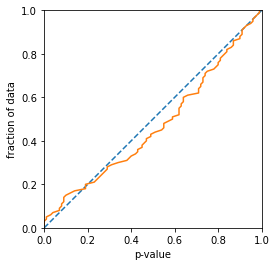

  1%|▊                                                                                 | 1/100 [00:04<07:15,  4.40s/it]

P-value: 0.5
Test stat: 0.16335324119336225
Null dist: [0.15787475450285038, 0.15971123796061026, 0.1744362204554889, 0.1772384322172904, 0.16349820274482663]


  2%|█▋                                                                                | 2/100 [00:08<06:57,  4.26s/it]

P-value: 0.83
Test stat: 0.16016918659190638
Null dist: [0.16846537432739095, 0.1670938391807233, 0.1771823949139787, 0.16276185622155626, 0.17170123703776863]


  3%|██▍                                                                               | 3/100 [00:12<06:40,  4.13s/it]

P-value: 0.89
Test stat: 0.15414541165163487
Null dist: [0.15866086393866863, 0.1568748533460982, 0.16814528423021036, 0.15660611575109695, 0.1568769160242116]


  4%|███▎                                                                              | 4/100 [00:15<06:24,  4.00s/it]

P-value: 0.64
Test stat: 0.15698331696454537
Null dist: [0.15640782896144523, 0.16520793873849016, 0.17268057993122365, 0.1517687881801988, 0.16282467007523527]


  5%|████                                                                              | 5/100 [00:19<06:16,  3.96s/it]

P-value: 0.33
Test stat: 0.16291923008409803
Null dist: [0.16056813833918437, 0.1606056917127322, 0.15377193339105732, 0.16011002023297627, 0.16833886768567674]


  6%|████▉                                                                             | 6/100 [00:23<06:12,  3.97s/it]

P-value: 0.85
Test stat: 0.1523343782233093
Null dist: [0.16646636132085246, 0.16453108819669615, 0.1588091774788607, 0.17508041270475516, 0.17494426974878796]


  7%|█████▋                                                                            | 7/100 [00:27<06:04,  3.91s/it]

P-value: 0.49
Test stat: 0.16116785160849856
Null dist: [0.1581970597990695, 0.16821210978154932, 0.15894814427421977, 0.1754030551518907, 0.15734321808510754]


  8%|██████▌                                                                           | 8/100 [00:31<06:03,  3.95s/it]

P-value: 0.52
Test stat: 0.16509735805606884
Null dist: [0.1633625185774139, 0.16389312332719363, 0.15848497815730123, 0.1669788879463745, 0.1698859317433834]


  9%|███████▍                                                                          | 9/100 [00:35<06:01,  3.97s/it]

P-value: 0.0
Test stat: 0.18102029370289563
Null dist: [0.16180757555508207, 0.15842612016582858, 0.16385547454617222, 0.1633334146280333, 0.16888233975702183]


 10%|████████                                                                         | 10/100 [00:39<06:01,  4.01s/it]

P-value: 0.49
Test stat: 0.16387257894492036
Null dist: [0.1672248843063595, 0.18365663188056425, 0.1663489303255652, 0.15794200034414985, 0.15451097145406256]


 11%|████████▉                                                                        | 11/100 [00:43<06:01,  4.06s/it]

P-value: 0.48
Test stat: 0.16134156555805956
Null dist: [0.16245863158912377, 0.16209739939582968, 0.15927187358011408, 0.16327966072269506, 0.16272537604367288]


 12%|█████████▋                                                                       | 12/100 [00:48<06:04,  4.14s/it]

P-value: 0.14
Test stat: 0.16898833935962698
Null dist: [0.1707490092271613, 0.16060573946705037, 0.16352347887876262, 0.16695755361780407, 0.15473239845599918]


 13%|██████████▌                                                                      | 13/100 [00:52<06:02,  4.17s/it]

P-value: 0.75
Test stat: 0.15829331614512354
Null dist: [0.15579811937128318, 0.15563923893019938, 0.17058143213214438, 0.16270913030640521, 0.17781884397558922]


 14%|███████████▎                                                                     | 14/100 [00:56<05:55,  4.14s/it]

P-value: 0.27
Test stat: 0.16715119698569791
Null dist: [0.15916418790673037, 0.17353533619672512, 0.1693708633999289, 0.1668584189163178, 0.16045124175718917]


 15%|████████████▏                                                                    | 15/100 [01:00<05:48,  4.10s/it]

P-value: 0.05
Test stat: 0.17595433576814368
Null dist: [0.1632010421078398, 0.1646526014569879, 0.15666711609327844, 0.16989706917436675, 0.1667394609356997]


 16%|████████████▉                                                                    | 16/100 [01:04<05:42,  4.08s/it]

P-value: 0.43
Test stat: 0.1607513383643211
Null dist: [0.1637216256402635, 0.16383243836732864, 0.16797131176829327, 0.15066305274568292, 0.16762324403925466]


 17%|█████████████▊                                                                   | 17/100 [01:08<05:36,  4.05s/it]

P-value: 0.54
Test stat: 0.16622512846856963
Null dist: [0.1677946494672934, 0.15836816313792335, 0.16696466674640253, 0.17089570253901665, 0.17993126423098893]


 18%|██████████████▌                                                                  | 18/100 [01:12<05:30,  4.02s/it]

P-value: 0.12
Test stat: 0.16802082726514944
Null dist: [0.1575699620625295, 0.15226637480406624, 0.1612659251909051, 0.15574325607253692, 0.15061222912416405]


 19%|███████████████▍                                                                 | 19/100 [01:16<05:25,  4.02s/it]

P-value: 0.18
Test stat: 0.16825599317770323
Null dist: [0.16457313324191802, 0.1534401072153182, 0.1581344571345482, 0.16437096825851805, 0.1376189438643053]


 20%|████████████████▏                                                                | 20/100 [01:20<05:22,  4.03s/it]

P-value: 0.11
Test stat: 0.1706411950612564
Null dist: [0.14995873393824133, 0.17551646400175225, 0.163603061716189, 0.1552560376033041, 0.1511131995535404]


 21%|█████████████████                                                                | 21/100 [01:24<05:17,  4.02s/it]

P-value: 0.97
Test stat: 0.15239940528969886
Null dist: [0.17307215323315206, 0.17840683676574298, 0.16394434008826975, 0.17231347646826356, 0.15065197434576927]


 22%|█████████████████▊                                                               | 22/100 [01:28<05:13,  4.02s/it]

P-value: 0.04
Test stat: 0.17498911940534845
Null dist: [0.15968776438630405, 0.1506327813689804, 0.16248064286203778, 0.1695017829436365, 0.1630071154083519]


 23%|██████████████████▋                                                              | 23/100 [01:32<05:13,  4.08s/it]

P-value: 0.23
Test stat: 0.1720747679469049
Null dist: [0.16401042332462024, 0.19246518218107944, 0.17339932466037666, 0.16880795944104532, 0.1648763586395361]


 24%|███████████████████▍                                                             | 24/100 [01:37<05:14,  4.14s/it]

P-value: 0.69
Test stat: 0.16241309133564263
Null dist: [0.1770238661538739, 0.15153126740487433, 0.15089242458614327, 0.15379181761795646, 0.1687186339048523]


 25%|████████████████████▎                                                            | 25/100 [01:41<05:10,  4.14s/it]

P-value: 0.75
Test stat: 0.15221048473687804
Null dist: [0.1638824019399744, 0.15392958384709277, 0.1454908220185127, 0.1561989498678884, 0.16126649049079833]


 26%|█████████████████████                                                            | 26/100 [01:45<05:07,  4.15s/it]

P-value: 0.4
Test stat: 0.16793573456888833
Null dist: [0.15673241807416427, 0.15555764401422167, 0.17014050216589693, 0.16344368849880786, 0.1565083391236124]


 27%|█████████████████████▊                                                           | 27/100 [01:49<05:01,  4.13s/it]

P-value: 0.1
Test stat: 0.16735189513684856
Null dist: [0.14892797852587436, 0.1590628246548894, 0.15611905512369117, 0.16020362835628954, 0.1561353426429457]


 28%|██████████████████████▋                                                          | 28/100 [01:53<04:59,  4.16s/it]

P-value: 0.05
Test stat: 0.17525226829542473
Null dist: [0.161683956111618, 0.16627129037534272, 0.16361943918214605, 0.16022623634558042, 0.16276373039752912]


 29%|███████████████████████▍                                                         | 29/100 [01:57<04:53,  4.13s/it]

P-value: 0.44
Test stat: 0.164117926732669
Null dist: [0.1524970303962201, 0.15128871183112924, 0.15210548370118704, 0.16589599947061517, 0.16890204561749267]


 30%|████████████████████████▎                                                        | 30/100 [02:01<04:44,  4.06s/it]

P-value: 0.34
Test stat: 0.16703796979331376
Null dist: [0.1684409626679756, 0.15330809815118918, 0.16051583473926134, 0.1687096556367781, 0.1611530139495978]


 31%|█████████████████████████                                                        | 31/100 [02:05<04:39,  4.04s/it]

P-value: 0.32
Test stat: 0.16834935323461797
Null dist: [0.1689387477720885, 0.15961080843027364, 0.16216252043243173, 0.15021119859391052, 0.15576962684385154]


 32%|█████████████████████████▉                                                       | 32/100 [02:09<04:32,  4.01s/it]

P-value: 0.11
Test stat: 0.16805057119218814
Null dist: [0.17336283702303457, 0.1587944033997859, 0.16670049545679944, 0.14083223789370103, 0.17224387507955485]


 33%|██████████████████████████▋                                                      | 33/100 [02:13<04:25,  3.96s/it]

P-value: 0.33
Test stat: 0.16386785775362722
Null dist: [0.16313607620770565, 0.17212526323599298, 0.15985112999479845, 0.16427019053820524, 0.1545572723923876]


 34%|███████████████████████████▌                                                     | 34/100 [02:17<04:17,  3.90s/it]

P-value: 0.5
Test stat: 0.15851626745290548
Null dist: [0.16217412985334134, 0.15401407754540186, 0.15019550991821173, 0.15908836867027065, 0.16856387277028673]


 35%|████████████████████████████▎                                                    | 35/100 [02:20<04:12,  3.88s/it]

P-value: 0.58
Test stat: 0.16200909846865696
Null dist: [0.16748475699814414, 0.16328679152691983, 0.1682275949598232, 0.16735622373937864, 0.1635289963697243]


 36%|█████████████████████████████▏                                                   | 36/100 [02:24<04:09,  3.89s/it]

P-value: 0.6
Test stat: 0.15923031987118785
Null dist: [0.17029683938734708, 0.15751762800866875, 0.15215855033631365, 0.14796981221844518, 0.16577185518074766]


 37%|█████████████████████████████▉                                                   | 37/100 [02:28<04:05,  3.90s/it]

P-value: 0.91
Test stat: 0.1562562437212771
Null dist: [0.17639118254687003, 0.15676026341405558, 0.1621931181399392, 0.16685734194214508, 0.15902247844126083]


 38%|██████████████████████████████▊                                                  | 38/100 [02:32<04:01,  3.89s/it]

P-value: 0.94
Test stat: 0.1535928596694136
Null dist: [0.15786357834683107, 0.165520881437909, 0.16816853035389645, 0.16186175468341857, 0.15666996114578002]


 39%|███████████████████████████████▌                                                 | 39/100 [02:36<04:04,  4.01s/it]

P-value: 0.43
Test stat: 0.1639663025645467
Null dist: [0.17621716444602353, 0.1561397225037826, 0.15306142461260674, 0.17007499131135972, 0.1707808480040658]


 40%|████████████████████████████████▍                                                | 40/100 [02:40<03:57,  3.96s/it]

P-value: 0.38
Test stat: 0.16439292890641466
Null dist: [0.16693678962179015, 0.16095221509646662, 0.15867874546324, 0.15962310115691292, 0.15767580264849368]


 41%|█████████████████████████████████▏                                               | 41/100 [02:44<03:50,  3.91s/it]

P-value: 0.74
Test stat: 0.1595089893591266
Null dist: [0.16766884126431947, 0.15642343844618622, 0.16762661482865293, 0.15622990029810813, 0.17479833537223866]


 42%|██████████████████████████████████                                               | 42/100 [02:48<03:48,  3.94s/it]

P-value: 0.89
Test stat: 0.15313373181867207
Null dist: [0.16223553672976831, 0.1636225957537596, 0.16247180546378848, 0.17661267789445867, 0.15646383889483673]


 43%|██████████████████████████████████▊                                              | 43/100 [02:52<03:47,  3.99s/it]

P-value: 0.2
Test stat: 0.16951391747605737
Null dist: [0.15666887365348148, 0.16462199072588768, 0.16173387755456636, 0.16784689596388114, 0.1693601441529271]


 44%|███████████████████████████████████▋                                             | 44/100 [02:57<03:47,  4.07s/it]

P-value: 0.45
Test stat: 0.16380844075241785
Null dist: [0.1679986818616308, 0.16143408639906076, 0.16453911150933576, 0.15357696479486493, 0.15751989395550958]


 45%|████████████████████████████████████▍                                            | 45/100 [03:00<03:41,  4.03s/it]

P-value: 0.08
Test stat: 0.1736877135957341
Null dist: [0.1520295964552435, 0.16242719652478355, 0.172968817235299, 0.16084018683625134, 0.18226373182468658]


 46%|█████████████████████████████████████▎                                           | 46/100 [03:04<03:37,  4.03s/it]

P-value: 0.25
Test stat: 0.17040954825098997
Null dist: [0.1619434245538628, 0.1601243594836539, 0.16505548105624468, 0.17046651084266418, 0.170661994345377]


 47%|██████████████████████████████████████                                           | 47/100 [03:08<03:31,  3.98s/it]

P-value: 0.63
Test stat: 0.16017489004150998
Null dist: [0.16335035907387263, 0.1648704430437412, 0.16658735306986938, 0.17292679741407135, 0.16022157212031962]


 48%|██████████████████████████████████████▉                                          | 48/100 [03:12<03:25,  3.95s/it]

P-value: 0.01
Test stat: 0.17909172979107968
Null dist: [0.15757698367745265, 0.16005469472860112, 0.15508879283361243, 0.16411870193957934, 0.16873556785713772]


 49%|███████████████████████████████████████▋                                         | 49/100 [03:16<03:20,  3.94s/it]

P-value: 0.54
Test stat: 0.15989445683798986
Null dist: [0.1624951298364451, 0.14878394196637734, 0.14681111691810966, 0.14997634652055392, 0.15786305387609334]


 50%|████████████████████████████████████████▌                                        | 50/100 [03:20<03:16,  3.92s/it]

P-value: 0.89
Test stat: 0.1524925238166256
Null dist: [0.16429113216342484, 0.16188368357156457, 0.16932538481022197, 0.16842674013195003, 0.16135429401032098]


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:24<03:13,  3.95s/it]

P-value: 0.42
Test stat: 0.16313430895951808
Null dist: [0.1713389665647871, 0.15489303149473732, 0.15273693194057425, 0.15253831510041782, 0.16484620928824634]


 52%|██████████████████████████████████████████                                       | 52/100 [03:28<03:08,  3.93s/it]

P-value: 0.84
Test stat: 0.15374595858402618
Null dist: [0.16708913160105787, 0.16550381069651543, 0.16465278424016883, 0.17065546906581586, 0.1622539314135466]


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:32<03:04,  3.92s/it]

P-value: 0.01
Test stat: 0.17945281440804872
Null dist: [0.16720789822786897, 0.16419606856650404, 0.15715278732258509, 0.1604420761912445, 0.1764131586289297]


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:36<03:00,  3.93s/it]

P-value: 0.73
Test stat: 0.1566481105426174
Null dist: [0.17154083336400805, 0.14703120465233455, 0.15993538143291486, 0.16678114119940568, 0.1707601782351983]


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:40<02:56,  3.93s/it]

P-value: 0.49
Test stat: 0.16158013795215742
Null dist: [0.16322197269620098, 0.154386882125517, 0.15219319890601546, 0.1573446751336498, 0.1639366831195822]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:44<02:52,  3.93s/it]

P-value: 0.87
Test stat: 0.153037819357009
Null dist: [0.16308320193314463, 0.16537178745212489, 0.17453013696932618, 0.15873588230942737, 0.15819401915653442]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:47<02:47,  3.90s/it]

P-value: 0.8
Test stat: 0.15268446282096027
Null dist: [0.16396666221209677, 0.16390678097918432, 0.15761123307066305, 0.15102919808989912, 0.15610953507876124]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:51<02:43,  3.90s/it]

P-value: 0.05
Test stat: 0.1787506446751138
Null dist: [0.17587743750810847, 0.16257490552000498, 0.17350739900976353, 0.1598760098018921, 0.16756097601291198]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:55<02:38,  3.87s/it]

P-value: 0.04
Test stat: 0.17740597602532593
Null dist: [0.1758623942762234, 0.17598362419735758, 0.16632070536855748, 0.16140490311898448, 0.17055558003246873]


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:59<02:37,  3.93s/it]

P-value: 0.52
Test stat: 0.16311250210288009
Null dist: [0.17321177095620732, 0.17264456632933134, 0.1704011721611275, 0.1635786560457333, 0.15788870374407993]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:03<02:34,  3.96s/it]

P-value: 0.99
Test stat: 0.1530670427025992
Null dist: [0.16061765290345886, 0.15819389508562165, 0.16385776805476238, 0.1709211515433997, 0.17448342423146457]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:07<02:30,  3.97s/it]

P-value: 0.5
Test stat: 0.16370013200016476
Null dist: [0.16478896851322822, 0.1727969709750996, 0.16603607890719485, 0.16032610234686562, 0.1590325371040885]


 63%|███████████████████████████████████████████████████                              | 63/100 [04:11<02:26,  3.97s/it]

P-value: 0.8
Test stat: 0.15596824808685583
Null dist: [0.16037881167234946, 0.147006299295376, 0.1627432603329334, 0.1575818935180756, 0.17898905099728657]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:15<02:25,  4.05s/it]

P-value: 0.24
Test stat: 0.16869342723098124
Null dist: [0.15879000889524286, 0.16503005544848626, 0.17855302321085598, 0.1744207614187484, 0.1567702648878715]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:19<02:21,  4.03s/it]

P-value: 0.63
Test stat: 0.1625373150126478
Null dist: [0.1627783644387183, 0.163665358558152, 0.164286891263542, 0.16184610213441375, 0.17717095191186227]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:23<02:15,  4.00s/it]

P-value: 0.73
Test stat: 0.1612540169522415
Null dist: [0.1547031704317885, 0.16534300385859668, 0.17741386859497477, 0.16876708204715762, 0.15893975911010239]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:27<02:10,  3.95s/it]

P-value: 0.84
Test stat: 0.14916364688906625
Null dist: [0.148491726809031, 0.14124193890933157, 0.15465452440437688, 0.1523238452663238, 0.14983322990374714]


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:31<02:06,  3.94s/it]

P-value: 0.08
Test stat: 0.17042202882261592
Null dist: [0.15425575862015273, 0.17978160620253902, 0.17312148709296815, 0.15301935234551656, 0.18521154536413476]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:35<02:03,  3.97s/it]

P-value: 0.77
Test stat: 0.15724940077259686
Null dist: [0.16820477846972826, 0.15357407359253394, 0.17828130774440942, 0.16514520258547205, 0.1549864579145288]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:39<01:58,  3.96s/it]

P-value: 0.44
Test stat: 0.16641397844448957
Null dist: [0.17155851561439162, 0.15818410703975339, 0.171924204058573, 0.17377934834007114, 0.1710777417344993]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:43<01:58,  4.09s/it]

P-value: 0.46
Test stat: 0.16509037172216168
Null dist: [0.16560274454517143, 0.16633614210592573, 0.15321981744881774, 0.16320228033242778, 0.15944684332705816]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:47<01:53,  4.06s/it]

P-value: 0.81
Test stat: 0.15735995472782816
Null dist: [0.16263783230418338, 0.16538047630300778, 0.17462985879910098, 0.16758596685342653, 0.17044599937932736]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:51<01:48,  4.04s/it]

P-value: 0.94
Test stat: 0.15396121712257593
Null dist: [0.1694729849510882, 0.1652625147020883, 0.169915607923804, 0.1668687677126789, 0.17120173430321017]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [04:55<01:44,  4.02s/it]

P-value: 0.67
Test stat: 0.15993927163811394
Null dist: [0.16082167805386816, 0.1521619668273061, 0.16427733454936944, 0.1627813308483258, 0.15919339329541127]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [04:59<01:38,  3.95s/it]

P-value: 0.56
Test stat: 0.16080220469979079
Null dist: [0.1430338879877574, 0.15976606320872033, 0.15290508365460265, 0.16150548747540827, 0.1524826620440317]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:03<01:35,  3.96s/it]

P-value: 0.23
Test stat: 0.16895725181059584
Null dist: [0.1640640325654612, 0.1565553625646281, 0.15915042761368814, 0.17203708647524407, 0.16805280520847943]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:07<01:32,  4.03s/it]

P-value: 0.7
Test stat: 0.1552276759402712
Null dist: [0.15951477344983434, 0.1712546427662811, 0.16385669969039685, 0.15204951842656023, 0.1490642562070239]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:11<01:28,  4.01s/it]

P-value: 0.98
Test stat: 0.1499337400917723
Null dist: [0.1501960287885178, 0.16152105982871368, 0.158783616520922, 0.15724873008631435, 0.1595994715597202]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:15<01:24,  4.04s/it]

P-value: 0.15
Test stat: 0.17065539871273427
Null dist: [0.17290003858371994, 0.1689388384578363, 0.16894425958009374, 0.1618537126304851, 0.16021271552422078]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:19<01:19,  3.98s/it]

P-value: 0.21
Test stat: 0.16890194350814336
Null dist: [0.16972907959862904, 0.1584454936620835, 0.16590491650843442, 0.1599464113596204, 0.16218265292999623]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:23<01:15,  3.96s/it]

P-value: 0.39
Test stat: 0.16264212034886627
Null dist: [0.16502634993303622, 0.15108031964612112, 0.16375733957088445, 0.15809837257144965, 0.14568714132976623]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [05:27<01:11,  3.97s/it]

P-value: 0.02
Test stat: 0.1816482456022659
Null dist: [0.1673570503916999, 0.1660201702310704, 0.16775049118164165, 0.1676663334039601, 0.17052417088647887]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:32<01:11,  4.19s/it]

P-value: 0.21
Test stat: 0.17018107399346682
Null dist: [0.1704052405466232, 0.16844947510355301, 0.15207487467772318, 0.15623061328165144, 0.18300474028180103]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:37<01:11,  4.46s/it]

P-value: 0.12
Test stat: 0.1664832401274957
Null dist: [0.17225864911280608, 0.16014209480876185, 0.15700921050332928, 0.16157749030505786, 0.166860403633024]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:41<01:06,  4.43s/it]

P-value: 0.59
Test stat: 0.15822810614073402
Null dist: [0.16287893117746344, 0.15375948935210493, 0.15451310455708178, 0.16736319249299036, 0.157448593560378]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:45<00:59,  4.28s/it]

P-value: 0.74
Test stat: 0.15928897219915295
Null dist: [0.1585055080234763, 0.16617805261921748, 0.15508357114744586, 0.16731892021922012, 0.15139162240811999]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [05:49<00:53,  4.12s/it]

P-value: 0.63
Test stat: 0.15864062644271315
Null dist: [0.16292367673279584, 0.1647803116273865, 0.16182005523520648, 0.14829792954398757, 0.15020692849500805]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [05:53<00:49,  4.10s/it]

P-value: 0.79
Test stat: 0.1614552150819779
Null dist: [0.16939289563358673, 0.163679149312407, 0.1661141183709457, 0.1676331793706769, 0.16633019990124764]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [05:57<00:45,  4.09s/it]

P-value: 0.24
Test stat: 0.16902717720333604
Null dist: [0.1633058564350458, 0.16871658735030493, 0.16491730406641059, 0.16281268767424772, 0.1666253075735471]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:01<00:41,  4.10s/it]

P-value: 0.08
Test stat: 0.17263110395628511
Null dist: [0.15993094802925545, 0.15662968823750645, 0.15486197459976392, 0.16464538110976257, 0.13744074985716603]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:05<00:37,  4.12s/it]

P-value: 0.44
Test stat: 0.16339810795111165
Null dist: [0.1503712897658136, 0.17383601760200962, 0.16363173776512419, 0.16477477593231638, 0.16753933941010146]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:09<00:32,  4.07s/it]

P-value: 0.73
Test stat: 0.15656234168722327
Null dist: [0.16955012737737396, 0.14993877835410885, 0.16485212752022205, 0.15233198720610108, 0.15550321523814592]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:13<00:28,  4.01s/it]

P-value: 0.14
Test stat: 0.16981423006199292
Null dist: [0.15712651196437855, 0.16331826468946997, 0.1677307130110155, 0.144659419942605, 0.16110267952430812]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [06:17<00:23,  3.97s/it]

P-value: 0.48
Test stat: 0.1636023342306997
Null dist: [0.16183723348987145, 0.15913882177435323, 0.1548509195361547, 0.161214410287295, 0.17048289403610772]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [06:21<00:19,  3.97s/it]

P-value: 0.83
Test stat: 0.15887547472224617
Null dist: [0.17073278961974803, 0.1706516480383471, 0.15404169830378645, 0.16717455001968173, 0.16483518665869812]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [06:26<00:16,  4.10s/it]

P-value: 0.64
Test stat: 0.15622239763357315
Null dist: [0.14721708935540967, 0.16033035219931724, 0.15121749122074957, 0.15808733016211396, 0.1498259787597085]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [06:29<00:12,  4.06s/it]

P-value: 0.05
Test stat: 0.18015930477801445
Null dist: [0.1506959080512449, 0.17469457983918313, 0.15777775729998267, 0.16655750999903396, 0.16339535193722676]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [06:33<00:08,  4.03s/it]

P-value: 0.87
Test stat: 0.15660853908672956
Null dist: [0.16468601949567108, 0.1597429035829402, 0.1633439430185064, 0.14679373939411244, 0.1610297514240664]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [06:37<00:04,  4.04s/it]

P-value: 0.93
Test stat: 0.15130755533068874
Null dist: [0.16569783402836202, 0.17006811997131632, 0.1639833320627856, 0.16711452499117274, 0.1557776032465421]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:41<00:00,  4.02s/it]

P-value: 0.91
Test stat: 0.1588739566407451
Null dist: [0.17663856872650618, 0.1695736332168094, 0.1748789333887819, 0.17204236615857693, 0.1642504079947622]


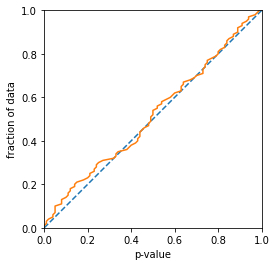

In [27]:
power, pvalues_list = estimate_power(SIMULATIONS[0], n_jobs=4)

In [24]:
import matplotlib.pyplot as plt
def plot_power2(): 
    
    sim_title = [
        #"Linear", 
        "Independence"
    ]
    sim = multimodal_independence
    power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/multimodal_independence_power1000.csv',
                                      delimiter=',')
    plt.plot(power)
    plt.yticks([0, 1])
    plt.axhline(y=0.05, color='b', linestyle='--')
    positions = (0, 3, 5)
    labels = ("100", "65", "105")
    plt.xticks(positions, labels)
    plt.xlabel("Sample Size")
    plt.ylabel("Mean Power from 100 Reps")
    plt.savefig("C:/Users/siptest/Desktop/NDD/Independence_UF_HonestSampling1000.jpg", bbox_inches='tight')
    

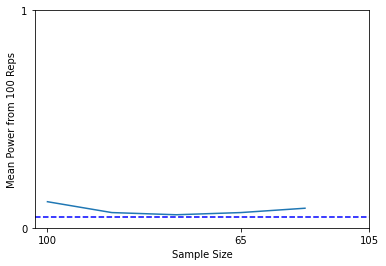

In [25]:
plot_power2()